# Table of Contents
* [Introduction](#intro)
* [Part 1: Data Import, Cleaning, and Merging](#p1)
    * [1.1 Importing COVID data from CSV](#p1.1)
    * [1.2 Importing sunshine duration data from webpage](#p1.2)
    * [1.3 Merging datasets](#p1.3)
    * [1.4 Data cleaning](#p1.4)
        * [1.4.1 Duplicates](#p1.4.1)
        * [1.4.2 Inspecting fixed variables](#p1.4.2)
        * [1.4.3 Inspecting daily updated variables](#p1.4.3)
        * [1.4.4 Imputation](#p1.4.4)
    * [1.5 Sampling bias from merging and cleaning](#p1.5)
        * [1.5.1 New cases per million](#p1.5.1)
        * [1.5.2 GDP per capita](#p1.5.2)
        * [1.5.3 Population](#p1.5.3)
* [Part 2: Data Exploration](#p2)
    * [2.1 Time series data](#p2.1)
    * [2.2 Fixed data](#p2.2)
* [Part 3: Drill Down into a Subset of Data](#p3)
    * [3.1 Rank correlation](#p3.1)
    * [3.2 Time series cross correlation](#p3.2)
* [Conclusion](#conclusion)
* [References](#ref)

# Introduction<a name="intro"></a>

* Walrand[<sup>1</sup>](#1) reported a linear correlation between latitude and the surge of daily new COVID-19 cases in most European countries during the autumn of 2020. The research suggests the drops in sun UV daily dose and the resulting decrease in blood 25-hydroxyvitamin D (25(OH)D) concentration as a contributing factor.<br><br>
* Above research used theoretical sun UV daily dose, expressed as a fraction at the country population weighted centre latitude versus the latitude 0°.<br><br>
* This project attempts to reproduce the correlation between daily new COVID cases and the sunshine duration. Sunshine duration is 
><em>a climatological indicator, measuring duration of sunshine in given period (usually, a day or a year) for a given location on Earth, typically expressed as an averaged value over several years[<sup>2</sup>](#2).</em>
* We also look at this correlation in countries outside of Europe.


# Part 1: Data Import, Cleaning, and Merging<a name="p1"></a>

This project uses seven packages below. If necessary please uncomment and install them before running the rest of the cells.

In [1]:
# install.packages("tidyverse")
# install.packages("data.table")
# install.packages("rvest")
# install.packages("countrycode")
# install.packages("zoo")
# install.packages("gridExtra")
# install.packages("ggpubr")

Load the packages required to run the project.

In [2]:
library(tidyverse)
library(data.table)
library(rvest)
library(countrycode)
library(zoo)
library(gridExtra)
library(ggpubr)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose



Attaching package: 'rvest'


The following object is masked from 'package:readr':

    guess_encoding



Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'gridExtra' was built under R version 4.2.2"

Attaching package: 'gridExtra'


The following obj

## 1.1 Importing COVID data from CSV<a name="p1.1"></a>

We will first import `owid-covid-data.csv` which has been downloaded from Our World in Data[<sup>3</sup>](#3).

In [3]:
unzip("owid-covid-data.zip", list = T) # view the files
unzip("owid-covid-data.zip", exdir = '.') # extract the files

Name,Length,Date
<chr>,<dbl>,<dttm>
owid-covid-data.csv,64555976,2022-10-23 09:48:00


In [4]:
covid_data <- fread("owid-covid-data.csv") # read the csv file
dim(covid_data) # display the dimension of covid_data
head(covid_data) # check the first few rows
tail(covid_data) # check the last few rows

[1] 229445     67

iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,⋯,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Asia,Afghanistan,2020-02-24,5,5,NA,NA,NA,NA,⋯,NA,37.746,0.5,64.83,0.511,40099462,NA,NA,NA,NA
AFG,Asia,Afghanistan,2020-02-25,5,0,NA,NA,NA,NA,⋯,NA,37.746,0.5,64.83,0.511,40099462,NA,NA,NA,NA
AFG,Asia,Afghanistan,2020-02-26,5,0,NA,NA,NA,NA,⋯,NA,37.746,0.5,64.83,0.511,40099462,NA,NA,NA,NA
AFG,Asia,Afghanistan,2020-02-27,5,0,NA,NA,NA,NA,⋯,NA,37.746,0.5,64.83,0.511,40099462,NA,NA,NA,NA
AFG,Asia,Afghanistan,2020-02-28,5,0,NA,NA,NA,NA,⋯,NA,37.746,0.5,64.83,0.511,40099462,NA,NA,NA,NA
AFG,Asia,Afghanistan,2020-02-29,5,0,0.714,NA,NA,NA,⋯,NA,37.746,0.5,64.83,0.511,40099462,NA,NA,NA,NA


iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,⋯,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZWE,Africa,Zimbabwe,2022-10-17,257893,0,20.571,5606,0,0.286,⋯,30.7,36.791,1.7,61.49,0.571,15993524,NA,NA,NA,NA
ZWE,Africa,Zimbabwe,2022-10-18,257893,0,20.571,5606,0,0.286,⋯,30.7,36.791,1.7,61.49,0.571,15993524,NA,NA,NA,NA
ZWE,Africa,Zimbabwe,2022-10-19,257893,0,13.571,5606,0,0.286,⋯,30.7,36.791,1.7,61.49,0.571,15993524,NA,NA,NA,NA
ZWE,Africa,Zimbabwe,2022-10-20,257893,0,9.429,5606,0,0.143,⋯,30.7,36.791,1.7,61.49,0.571,15993524,NA,NA,NA,NA
ZWE,Africa,Zimbabwe,2022-10-21,257893,0,9.429,5606,0,0.143,⋯,30.7,36.791,1.7,61.49,0.571,15993524,NA,NA,NA,NA
ZWE,Africa,Zimbabwe,2022-10-22,257893,0,9.429,5606,0,0.143,⋯,30.7,36.791,1.7,61.49,0.571,15993524,NA,NA,NA,NA


`owid-covid-data.csv` includes a wide range of data related to COVID, such as vaccinations, hospital and ICU, reproduction rate, etc.<br> For this project we will select:
* New cases (Daily updated data) - `total_cases`, `new_cases`, `new_cases_smoothed`, `total_cases_per_million`, `new_cases_per_million`, `new_cases_smoothed_per_million`<br><br>
* Policy responses (Daily updated data) - `stringency_index`<br><br>
* Other variables of interest (Fixed data) - `iso_code`, `continent`, `location`, `date`, `population`, `population_density`, `median_age`, `aged_65_older`, `aged_70_older`, `gdp_per_capita`, `extreme_poverty`, `cardiovasc_death_rate`, `diabetes_prevalence`, `female_smokers`, `male_smokers`, `handwashing_facilities`, `hospital_beds_per_thousand`, `life_expectancy`, `human_development_index`

In [5]:
covid_new_cases <- covid_data[,c(1:7, 11:13, 48:63)] # select columns from covid_data
dim(covid_new_cases) # check the dimension of covid_new_cases to make sure the number of columns has decreased
head(covid_new_cases) # check the first few rows

[1] 229445     26

iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,⋯,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population
<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Asia,Afghanistan,2020-02-24,5,5,NA,0.125,0.125,NA,⋯,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462
AFG,Asia,Afghanistan,2020-02-25,5,0,NA,0.125,0.000,NA,⋯,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462
AFG,Asia,Afghanistan,2020-02-26,5,0,NA,0.125,0.000,NA,⋯,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462
AFG,Asia,Afghanistan,2020-02-27,5,0,NA,0.125,0.000,NA,⋯,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462
AFG,Asia,Afghanistan,2020-02-28,5,0,NA,0.125,0.000,NA,⋯,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462
AFG,Asia,Afghanistan,2020-02-29,5,0,0.714,0.125,0.000,0.018,⋯,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462


In `iso_code`, there are values that are created by Our World in Data and not included in the standard ISO 3166-1 alpha-3 codes.<br>
We will find them by looking for `iso_code` that do not contain exactly three characters and filter them out.

In [6]:
unique(covid_new_cases[,1:3][which(nchar(covid_new_cases$iso_code) != 3)]) # display "iso_code" that do not contain exactly 3 characters
covid_data_iso <- covid_new_cases[which(nchar(covid_new_cases$iso_code) == 3)] # only keep "iso_code" that contain 3 characters
dim(covid_data_iso) # display the dimension of covid_new_iso to make sure the number of rows has decreased
print(paste(nrow(covid_data) - nrow(covid_data_iso), "rows have been dropped")) # display the number of rows that were dropped

iso_code,continent,location
<chr>,<chr>,<chr>
OWID_AFR,,Africa
OWID_ASI,,Asia
OWID_ENG,Europe,England
OWID_EUR,,Europe
OWID_EUN,,European Union
OWID_HIC,,High income
OWID_INT,,International
OWID_KOS,Europe,Kosovo
OWID_LIC,,Low income


[1] 211414     26

[1] "18031 rows have been dropped"


From `date` we will identify the month of the dates and include them as a column.

In [7]:
covid_data_month <-
    covid_data_iso %>%
    mutate(month = format(date, "%b"), .after = date) # Create a new column with abbreviated month names
dim(covid_data_month) # display the dimension of covid_data_month to make sure the number of columns has increased
head(covid_data_month) # check the first few rows

[1] 211414     27

iso_code,continent,location,date,month,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,⋯,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population
<chr>,<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Asia,Afghanistan,2020-02-24,Feb,5,5,NA,0.125,0.125,⋯,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462
AFG,Asia,Afghanistan,2020-02-25,Feb,5,0,NA,0.125,0.000,⋯,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462
AFG,Asia,Afghanistan,2020-02-26,Feb,5,0,NA,0.125,0.000,⋯,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462
AFG,Asia,Afghanistan,2020-02-27,Feb,5,0,NA,0.125,0.000,⋯,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462
AFG,Asia,Afghanistan,2020-02-28,Feb,5,0,NA,0.125,0.000,⋯,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462
AFG,Asia,Afghanistan,2020-02-29,Feb,5,0,0.714,0.125,0.000,⋯,NA,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462


## 1.2 Importing sunshine duration data from webpage<a name="p1.2"></a>

We will then import the sunshine duration data from Wikipedia[<sup>4</sup>](#4).

In [8]:
url <- "https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration" # save the URL in a variable
wikipedia <- 
    read_html(url) %>% 
    html_nodes('table.wikitable') %>% 
    html_table(header = TRUE) # read the tables from URL and save them in another variable

The Wikipedia page has six `wikitable` (one per continent except for Antarctica), so `wikipedia` is a list of six tibbles.<br>
We will bind them into one table.

In [9]:
sunshine_data <- rbindlist(wikipedia) # bind the list of tibbles into one table
dim(sunshine_data) # display the dimension of sunshine_data
head(sunshine_data) # check the first few rows
tail(sunshine_data) # check the last few rows

[1] 391  16

Country,City,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year,Ref.
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Ivory Coast,Gagnoa,183.0,180.0,196.0,188.0,181.0,118.0,97.0,80.0,110.0,155.0,171,164.0,"1,823.0",[2]
Ivory Coast,Bouaké,242.0,224.0,219.0,194.0,208.0,145.0,104.0,82.0,115.0,170.0,191,198.0,"2,092.0",[2]
Ivory Coast,Abidjan,223.0,223.0,239.0,214.0,205.0,128.0,137.0,125.0,139.0,215.0,224,224.0,"2,296.0",[2]
Ivory Coast,Odienné,242.0,220.2,217.3,214.7,248.8,221.8,183.5,174.5,185.4,235.8,252,242.6,"2,638.6",[3]
Ivory Coast,Ferké,279.0,249.0,253.0,229.0,251.0,221.0,183.0,151.0,173.0,245.0,261,262.0,"2,757.0",[2]
Benin,Cotonou,213.9,210.0,223.2,219.0,213.9,141.0,136.4,148.8,165.0,207.7,243,223.2,"2,345.2",[4]


Country,City,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year,Ref.
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
New Zealand,Christchurch,224.4,190.5,177.4,155.6,133.3,117.7,124.8,149.0,166.6,201.3,215.3,214.3,"2,070.2",?
New Zealand,Wellington,240.3,205.0,194.7,153.8,126.0,102.3,111.4,137.2,163.2,191.1,210.8,222.9,"2,058.7",?
New Zealand,Hamilton,229.8,192.9,193.3,165.1,138.3,112.8,126.4,144.1,147.5,174.8,187.1,207.6,"2,019.6",?
New Zealand,Auckland,228.8,194.9,189.2,157.3,139.8,110.3,128.1,142.9,148.6,178.1,188.1,197.2,"2,003.1",?
Fiji,Suva,192.2,178.0,170.5,153.0,145.7,141.0,136.4,142.6,135.0,164.3,168.0,195.3,"1,922.0",[193]
New Zealand,Dunedin,179.6,158.0,146.1,125.9,108.4,95.3,110.6,122.2,136.8,165.5,166.9,168.3,"1,683.7",[194]


`Year` shows the yearly sunshine duration per country. Convert `Year` from character to double.

In [10]:
sunshine_data$Year <- as.numeric(sub(",","",sunshine_data$Year)) # Convert "Year" to double
typeof(sunshine_data$Year) # Check if it was converted successfully

[1] "double"

Some countries in `sunshine_data` has data from several cities. <br>
We will calculate their mean so that there are one row of data per country. <br>
In a longer project ideally this calculations would be weighted by population, but in this case we are using the simple mean calculation.

In [11]:
avg_sunshine_per_country <- 
    sunshine_data %>%
    select(-c(City, Ref.)) %>% # remove "City" and "Ref." columns
    group_by(Country) %>%
    summarise_all(mean) %>% # calculate mean per country
    mutate_if(is.numeric, round, 1) # round all numeric columns to one decimal place
head(avg_sunshine_per_country) # check the first few rows

Country,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,177.2,178.6,204.5,232.5,310.3,353.4,356.8,339.7,303.9,282.6,253.2,182.4,3175.1
Albania,124.0,125.0,165.0,191.0,263.0,298.0,354.0,327.0,264.0,218.0,127.0,88.0,2544.0
Algeria,223.3,220.2,262.2,292.5,323.8,312.0,353.2,325.4,262.5,269.5,225.0,204.4,3266.5
Angola,219.0,208.0,213.0,199.0,233.0,223.0,175.0,150.0,145.0,164.0,199.0,212.0,2341.0
Argentina,238.2,207.1,185.1,170.6,151.5,123.4,138.6,170.4,174.6,208.6,222.8,229.4,2220.3
Armenia,93.0,108.0,162.0,177.0,242.0,297.0,343.0,332.0,278.0,212.0,138.0,92.0,2474.0


To merge the sunshine duration data with COVID data, we will look up the ISO 3166-1 alpha-3 codes from country names and assign them to all rows of `avg_sunshine_per_country`.

In [12]:
avg_sunshine_per_iso <- 
    avg_sunshine_per_country %>% 
    mutate(iso_code = Country %>% countrycode(origin = 'country.name', destination = 'iso3c'), .before = Country) # assign ISO 3166-1 alpha-3 codes
head(avg_sunshine_per_iso) # check the first few rows to check that iso_code has been added

iso_code,Country,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Afghanistan,177.2,178.6,204.5,232.5,310.3,353.4,356.8,339.7,303.9,282.6,253.2,182.4,3175.1
ALB,Albania,124.0,125.0,165.0,191.0,263.0,298.0,354.0,327.0,264.0,218.0,127.0,88.0,2544.0
DZA,Algeria,223.3,220.2,262.2,292.5,323.8,312.0,353.2,325.4,262.5,269.5,225.0,204.4,3266.5
AGO,Angola,219.0,208.0,213.0,199.0,233.0,223.0,175.0,150.0,145.0,164.0,199.0,212.0,2341.0
ARG,Argentina,238.2,207.1,185.1,170.6,151.5,123.4,138.6,170.4,174.6,208.6,222.8,229.4,2220.3
ARM,Armenia,93.0,108.0,162.0,177.0,242.0,297.0,343.0,332.0,278.0,212.0,138.0,92.0,2474.0


We will also use `gather` to restructure all monthly sunshine duration into one column.

In [13]:
avg_sunshine_per_month <-
    avg_sunshine_per_iso %>% gather(month, sunshine_hours_month, Jan:Dec) # Create new columns "month" and "sumshine_hours_month"
colnames(avg_sunshine_per_month)[3] <- "sunshine_hours_year" # Rename the third column
dim(avg_sunshine_per_month) # display the dimension of avg_sunshine_per_month
head(avg_sunshine_per_month) # check the first few rows

[1] 1680    5

iso_code,Country,sunshine_hours_year,month,sunshine_hours_month
<chr>,<chr>,<dbl>,<chr>,<dbl>
AFG,Afghanistan,3175.1,Jan,177.2
ALB,Albania,2544.0,Jan,124.0
DZA,Algeria,3266.5,Jan,223.3
AGO,Angola,2341.0,Jan,219.0
ARG,Argentina,2220.3,Jan,238.2
ARM,Armenia,2474.0,Jan,93.0


`avg_sunshine_per_month` does not include data for all the countries that exist in `covid_data_month`. We will take a note of these missing countries to be investigated for sampling bias in [section 1.5](#p1.5).

In [14]:
no_sunshine_data <- 
    unique(covid_data_month$iso_code[which(covid_data_month$iso_code %in% avg_sunshine_per_month$iso_code == FALSE)]) # save the iso codes for countries without sunshine data in a variable
print(paste("We do not have sunshine hours data for ", length(no_sunshine_data), " countries")) # display the number of countries without sunshine duration data

[1] "We do not have sunshine hours data for  90  countries"


## 1.3 Merging datasets<a name="p1.3"></a>

We will now merge the two datasets `covid_data_month` and `avg_sunshine_per_month`.

In [15]:
merged_df <- covid_data_month %>% inner_join(avg_sunshine_per_month[, -2], by = c("iso_code", "month")) # inner join the two datasets
dim(merged_df) # display the dimension of merged_df
head(merged_df) # check the first few rows
tail(merged_df) # check the last few rows

[1] 134149     29

iso_code,continent,location,date,month,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,⋯,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,sunshine_hours_year,sunshine_hours_month
<chr>,<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Asia,Afghanistan,2020-02-24,Feb,5,5,NA,0.125,0.125,⋯,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462,3175.1,178.6
AFG,Asia,Afghanistan,2020-02-25,Feb,5,0,NA,0.125,0.000,⋯,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462,3175.1,178.6
AFG,Asia,Afghanistan,2020-02-26,Feb,5,0,NA,0.125,0.000,⋯,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462,3175.1,178.6
AFG,Asia,Afghanistan,2020-02-27,Feb,5,0,NA,0.125,0.000,⋯,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462,3175.1,178.6
AFG,Asia,Afghanistan,2020-02-28,Feb,5,0,NA,0.125,0.000,⋯,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462,3175.1,178.6
AFG,Asia,Afghanistan,2020-02-29,Feb,5,0,0.714,0.125,0.000,⋯,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462,3175.1,178.6


iso_code,continent,location,date,month,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,⋯,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,sunshine_hours_year,sunshine_hours_month
<chr>,<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZWE,Africa,Zimbabwe,2022-10-17,Oct,257893,0,20.571,16124.84,0,⋯,1.82,1.6,30.7,36.791,1.7,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-18,Oct,257893,0,20.571,16124.84,0,⋯,1.82,1.6,30.7,36.791,1.7,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-19,Oct,257893,0,13.571,16124.84,0,⋯,1.82,1.6,30.7,36.791,1.7,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-20,Oct,257893,0,9.429,16124.84,0,⋯,1.82,1.6,30.7,36.791,1.7,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-21,Oct,257893,0,9.429,16124.84,0,⋯,1.82,1.6,30.7,36.791,1.7,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-22,Oct,257893,0,9.429,16124.84,0,⋯,1.82,1.6,30.7,36.791,1.7,61.49,0.571,15993524,3065.4,279


## 1.4 Data cleaning<a name="p1.4"></a>

In this section we will inspect and clean `merged_df`.

### 1.4.1 Duplicates<a name="p1.4.1"></a>

Check that there are no duplicated rows in `merged_df`.

In [16]:
sum((duplicated(merged_df)))

[1] 0

### 1.4.2 Inspecting fixed variables<a name="p1.4.2"></a>

We will inspect and clean fixed variables, which are variables that are not updated daily.<br>
First let's create a table of count and percentage of NA values per variable.

In [17]:
na_df <- data.frame(colSums(is.na(merged_df))) # create a dataframe of sum of NA per column
colnames(na_df) <- "sum_of_na" # rename the column that shows sum of NAs
na_percentage_df <- na_df %>% mutate(percentage_na = round((sum_of_na / nrow(merged_df)) * 100, 2)) # calculate the percentage of NA values
na_percentage_df

,sum_of_na,percentage_na
,<dbl>,<dbl>
iso_code,0,0.00
continent,0,0.00
location,0,0.00
date,0,0.00
month,0,0.00
total_cases,2004,1.49
new_cases,2211,1.65
new_cases_smoothed,2926,2.18
total_cases_per_million,2004,1.49


We will remove the variables where missing data represent more than 10% of the total, which are all fixed variables.

In [18]:
columns_removed <- merged_df %>% select(colnames(merged_df)[which(na_percentage_df$percentage_na < 10)]) # remove the columns where more than 10% of data are missing
print(paste(sum(na_percentage_df$percentage_na > 10), "columns below have been dropped")) # display the number of columns that were removed
colnames(merged_df)[which(na_percentage_df$percentage_na > 10)] # display the column names that were removed

[1] "5 columns below have been dropped"


[1] "extreme_poverty"            "female_smokers"            
[3] "male_smokers"               "handwashing_facilities"    
[5] "hospital_beds_per_thousand"

For the remaining fixed variables, we want to check from which countries the data are missing.<br>
We will start by creating a table for number of observations per country.

In [19]:
observations_per_country <- 
    columns_removed %>% 
    count(iso_code) # count the number of observations per iso codes
colnames(observations_per_country)[2] <- "observations" # rename the column that shows the number of observations
head(observations_per_country) # check the first few rows

iso_code,observations
<chr>,<int>
AFG,972
AGO,947
ALB,971
ARE,998
ARG,1026
ARM,993


Then create a table showing the count of missing data per variable per country.

In [20]:
missing_data_count <- 
    columns_removed %>%
    select(-date) %>% # remove "date" column
    group_by(iso_code, location) %>% # group by iso codes and country names
    summarise_if(is.double, function(x) sum(is.na(x))) %>% # for numerical columns, show sum of NAs
    left_join(observations_per_country, by = "iso_code") # join observations_per_country to missing_data_count
dim(missing_data_count) # display the dimension of missing_data_count
head(missing_data_count) # check the first few rows

[1] 139  22

iso_code,location,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,stringency_index,population_density,⋯,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,population,sunshine_hours_year,sunshine_hours_month,observations
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
AFG,Afghanistan,0,2,7,0,2,7,32,0,⋯,0,0,0,0,0,0,0,0,0,972
AGO,Angola,0,0,5,0,0,5,27,0,⋯,0,0,0,0,0,0,0,0,0,947
ALB,Albania,13,13,18,13,13,18,17,0,⋯,0,0,0,0,0,0,0,0,0,971
ARE,United Arab Emirates,0,0,5,0,0,5,20,0,⋯,0,0,0,0,0,0,0,0,0,998
ARG,Argentina,62,68,73,62,68,73,47,0,⋯,0,0,0,0,0,0,0,0,0,1026
ARM,Armenia,27,32,37,27,32,37,993,0,⋯,0,0,0,0,0,0,0,0,0,993


For each fixed variables, calculate the percentage of missing data per country and filter for the ones that are missing 100%.<br>
Since these variables are not daily updated, fixed variables should either be 0% or 100% missing.
Data from these countries will be dropped in [Section 1.4.3](#p1.4.3).

In [21]:
missing_fixed_variables <- 
    missing_data_count %>%
    group_by(iso_code, location) %>%
    transmute(percentage_na_population_density = round((population_density / observations) * 100, 2), # calculate the NA percentage of "population_density" per country
              percentage_na_median_age = round((median_age / observations) * 100, 2), # calculate the NA percentage of "median_age" per country
              percentage_na_aged_65_older = round((aged_65_older / observations) * 100, 2), # calculate the NA percentage of "aged_65_older" per country
              percentage_na_aged_70_older = round((aged_70_older / observations) * 100, 2), # calculate the NA percentage of "aged_70_older" per country
              percentage_na_gdp_per_capita = round((gdp_per_capita / observations) * 100, 2), # calculate the NA percentage of "gdp_per_capita" per country
              percentage_na_cardiovasc_death_rate = round((cardiovasc_death_rate / observations) * 100, 2), # calculate the NA percentage of "cardiovasc_death_rate" per country
              percentage_na_diabetes_prevalence = round((diabetes_prevalence / observations) * 100, 2), # calculate the NA percentage of "diabetes_prevalence" per country
              percentage_na_human_development_index = round((human_development_index / observations) * 100, 2) # calculate the NA percentage of "human_development_index" per country
          ) %>%
    filter_if(is.double, any_vars(. == 100)) # filter for rows including any variables missing 100%
missing_fixed_variables

iso_code,location,percentage_na_population_density,percentage_na_median_age,percentage_na_aged_65_older,percentage_na_aged_70_older,percentage_na_gdp_per_capita,percentage_na_cardiovasc_death_rate,percentage_na_diabetes_prevalence,percentage_na_human_development_index
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FLK,Falkland Islands,100,100,100,100,100,100,100,100
FRO,Faeroe Islands,0,100,100,100,100,100,100,100
MCO,Monaco,0,100,100,100,100,100,0,100
PRI,Puerto Rico,0,0,0,0,0,0,0,100
PRK,North Korea,0,0,0,0,100,0,0,100
SOM,Somalia,0,0,0,0,100,0,0,100
SPM,Saint Pierre and Miquelon,100,100,100,100,100,100,100,100
SRB,Serbia,0,0,0,100,0,0,0,0
SSD,South Sudan,100,0,0,0,0,0,0,0


### 1.4.3 Inspecting daily updated variables<a name="p1.4.3"></a>

Here we will inspect the missing percentage of daily updated variables in relation to countries.<br>
Similar to fixed variables, we will calculate the percentage of missing data per country.<br>
This time we will filter for more than 10% missing values, since these variables are updated daily.

In [22]:
missing_daily_updated_variables <- 
    missing_data_count %>%
    group_by(iso_code, location) %>%
    transmute(percentage_na_stringency_index = round((stringency_index / observations) * 100, 2), # calculate the NA percentage of "stringency_index" per country
              percentage_na_total_cases = round((total_cases / observations) * 100, 2), # calculate the NA percentage of "total_cases" per country
              percentage_na_new_cases = round((new_cases / observations) * 100, 2), # calculate the NA percentage of "new_cases" per country
              percentage_na_new_cases_smoothed = round((new_cases_smoothed / observations) * 100, 2), # calculate the NA percentage of "new_cases_smoothed" per country
              percentage_na_total_cases_per_million = round((total_cases_per_million / observations) * 100, 2), # calculate the NA percentage of "total_cases_per_million" per country
              percentage_na_new_cases_per_million = round((new_cases_per_million / observations) * 100, 2), # calculate the NA percentage of "new_cases_per_million" per country
              percentage_na_new_cases_smoothed_per_million = round((new_cases_smoothed_per_million / observations) * 100, 2) # calculate the NA percentage of "new_cases_smoothed_per_million" per country
          ) %>%
    filter_if(is.double, any_vars(. > 10)) # filter for rows including any variables missing more than 10%
missing_daily_updated_variables

iso_code,location,percentage_na_stringency_index,percentage_na_total_cases,percentage_na_new_cases,percentage_na_new_cases_smoothed,percentage_na_total_cases_per_million,percentage_na_new_cases_per_million,percentage_na_new_cases_smoothed_per_million
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARM,Armenia,100,2.72,3.22,3.73,2.72,3.22,3.73
ERI,Eritrea,100,0.00,0.00,0.53,0.00,0.00,0.53
FLK,Falkland Islands,100,0.00,0.21,0.75,0.00,0.21,0.75
GNB,Guinea-Bissau,100,0.00,0.00,0.53,0.00,0.00,0.53
GNQ,Equatorial Guinea,100,0.00,0.11,0.63,0.00,0.11,0.63
MKD,North Macedonia,100,0.00,0.10,0.62,0.00,0.10,0.62
MNE,Montenegro,100,0.00,0.00,0.53,0.00,0.00,0.53
PRI,Puerto Rico,100,100.00,100.00,100.00,100.00,100.00,100.00
PRK,North Korea,100,81.82,81.82,82.38,81.82,81.82,82.38


Let's create a list iso codes from countries in `missing_fixed_variables` and `missing_daily_updated_variables`.

In [23]:
countries_to_drop <- 
    unique(c(missing_fixed_variables$iso_code, missing_daily_updated_variables$iso_code)) # unique list of "iso_code" from two grouped dataframes
print(paste("We are missing high percentage of data from ", length(countries_to_drop), " countries")) # display the number of countries in countries_to_drop

[1] "We are missing high percentage of data from  16  countries"


We will then drop rows that contain the 16 countries in `countries_to_drop`.

In [24]:
countries_removed <-
    columns_removed[which(columns_removed$iso_code %in% countries_to_drop == FALSE)] # remove countries from countries_to_drop
dim(countries_removed) # display the dimension of countries_removed
head(countries_removed) # check the first few rows

[1] 119009     24

iso_code,continent,location,date,month,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,⋯,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,population,sunshine_hours_year,sunshine_hours_month
<chr>,<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Asia,Afghanistan,2020-02-24,Feb,5,5,NA,0.125,0.125,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,178.6
AFG,Asia,Afghanistan,2020-02-25,Feb,5,0,NA,0.125,0.000,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,178.6
AFG,Asia,Afghanistan,2020-02-26,Feb,5,0,NA,0.125,0.000,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,178.6
AFG,Asia,Afghanistan,2020-02-27,Feb,5,0,NA,0.125,0.000,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,178.6
AFG,Asia,Afghanistan,2020-02-28,Feb,5,0,NA,0.125,0.000,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,178.6
AFG,Asia,Afghanistan,2020-02-29,Feb,5,0,0.714,0.125,0.000,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,178.6


Following removal of missing data in relation to countries, we will also inspect the daily updated variables in relation to dates.<br>
First we will create a table for number of observations per date.

In [25]:
observations_per_date <- 
    columns_removed %>% 
    count(date) # count the number of observations per date
colnames(observations_per_date)[2] <- "observations" # rename the column that shows the number of observations
head(observations_per_date) # check the first few rows

date,observations
<date>,<int>
2020-01-01,2
2020-01-02,2
2020-01-03,2
2020-01-04,3
2020-01-05,3
2020-01-06,6


We will calculate the median of observations per date, and create a plot to determine a cut off point for the start date.

[1] "Median value of observations per date is 139"


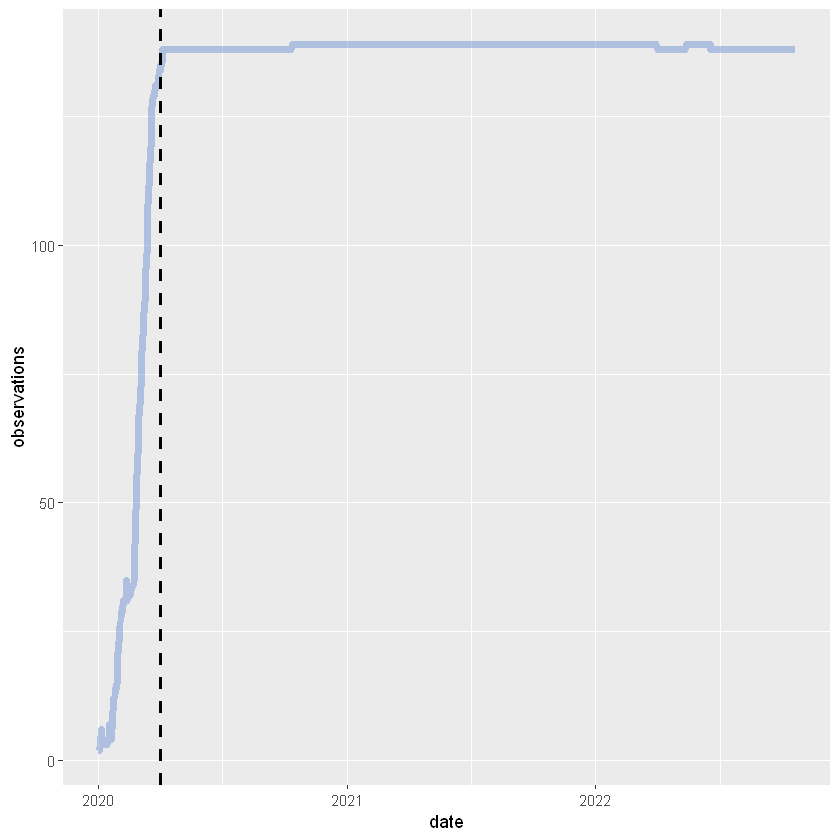

In [26]:
print(paste("Median value of observations per date is", median(observations_per_date$observations))) # display the median number of observations
ggplot(observations_per_date, aes(x = date, y = observations)) + 
    geom_line(colour = "#7294D4", size = 2, alpha = 0.5) + # create a line plot
    geom_vline(xintercept = as.Date("2020-04-01", "%Y-%m-%d"), size = 1, linetype = "dashed") # draw a line at 2020-04-01

The plot shows an increase in the number of observations in early 2020 till it reaches the median value of 139.<br>
This is because the countries were starting to collect the data in the first quarter of 2020.<br>
We will set the start date of this dataset to `2020-04-01` where the dashed line is.

In order to determine the end date of this dataset, we will first create a table showing the count of missing data per variable per date.<br>
We're skipping `per_million` variables since they are calculated from `total_cases`, `new_cases`, and `new_cases_smoothed`.

In [27]:
daily_na <-
    countries_removed %>%
    select(date, month, total_cases, new_cases, new_cases_smoothed, stringency_index) %>% # select daily updated variables without "per_million"
    group_by(date, month) %>% # group by "date" and "month"
    summarise_if(is.double, function(x) sum(is.na(x))) # for numerical columns, show sum of NAs
dim(daily_na) # display the dimension of daily_na
head(daily_na) # check the first few rows

[1] 1026    6

date,month,total_cases,new_cases,new_cases_smoothed,stringency_index
<date>,<chr>,<int>,<int>,<int>,<int>
2020-01-01,Jan,2,2,2,2
2020-01-02,Jan,2,2,2,2
2020-01-03,Jan,2,2,2,2
2020-01-04,Jan,3,3,3,3
2020-01-05,Jan,3,3,3,3
2020-01-06,Jan,6,6,6,6


Let's check the data from the last month (October 2022).

In [28]:
daily_na %>%
    filter(date >= as.Date("2022-10-01", "%Y-%m-%d")) # filter for dates in October 2022

date,month,total_cases,new_cases,new_cases_smoothed,stringency_index
<date>,<chr>,<int>,<int>,<int>,<int>
2022-10-01,Oct,0,0,0,28
2022-10-02,Oct,0,0,0,28
2022-10-03,Oct,0,0,0,32
2022-10-04,Oct,0,0,0,41
2022-10-05,Oct,0,0,0,45
2022-10-06,Oct,0,0,0,123
2022-10-07,Oct,0,0,0,123
2022-10-08,Oct,0,0,0,123
2022-10-09,Oct,0,0,0,123


We can see that the number of missing `stringency_index` increases before the number of missing `new_cases` and `new_cases_smoothed`.<br>
We will create a plot to determine a cut off point for the end date.

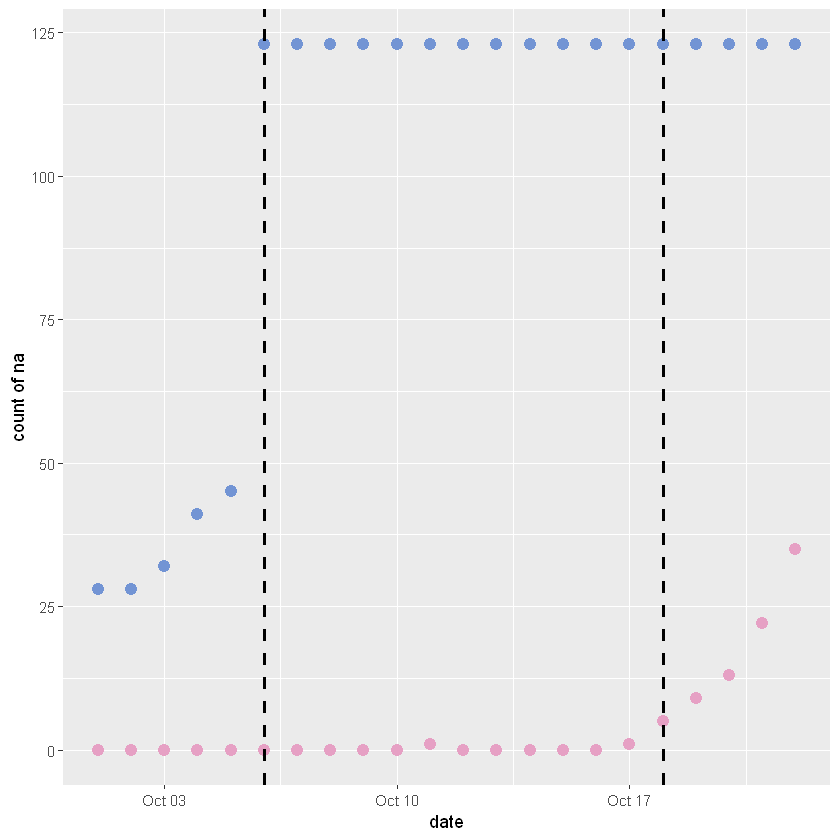

In [29]:
daily_na %>%
    filter(date >= as.Date("2022-10-01", "%Y-%m-%d")) %>% # filter for data in October 2022
    ggplot() + 
    geom_point(aes(x = date, y = new_cases), size = 3, color = "#E6A0C4") + # plot the missing number of "new_cases"
    geom_point(aes(x = date, y = stringency_index), size = 3, color = "#7294D4") + # plot the missing number of "stringency_index"
    geom_vline(xintercept = as.Date("2022-10-06", "%Y-%m-%d"), size = 1, linetype = "dashed") + # draw a line at 2022-10-06
    geom_vline(xintercept = as.Date("2022-10-18", "%Y-%m-%d"), size = 1, linetype = "dashed") + # draw a line at 2022-10-18
    ylab("count of na")

Although the number of missing `stringency_index` increases around `2022-10-06`, the number of missing `new_cases` doesn't start to increase till around `2022-10-18`. <br>We will set the start date of this dataset to `2022-10-18` and inpute the missing data for `stringency_index`.<br>
From `countries_removed` let's drop rows from dates before `2020-04-01` and after `2022-10-18`.

In [30]:
dates_removed <-
    countries_removed[which(countries_removed$date >= as.Date("2020-04-01", "%Y-%m-%d") & countries_removed$date <= as.Date("2022-10-18", "%Y-%m-%d"))] # remove the rows from dates before the start date and after the end date
dim(dates_removed) # display the dimension of dates_removed
head(dates_removed) # check the first few rows
tail(dates_removed) # check the last few rows

[1] 114319     24

iso_code,continent,location,date,month,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,⋯,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,population,sunshine_hours_year,sunshine_hours_month
<chr>,<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Asia,Afghanistan,2020-04-01,Apr,192,26,16.857,4.788,0.648,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-02,Apr,235,43,22.143,5.860,1.072,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-03,Apr,269,34,25.429,6.708,0.848,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-04,Apr,270,1,23.429,6.733,0.025,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-05,Apr,299,29,26.429,7.456,0.723,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-06,Apr,337,38,31.857,8.404,0.948,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5


iso_code,continent,location,date,month,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,⋯,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,population,sunshine_hours_year,sunshine_hours_month
<chr>,<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZWE,Africa,Zimbabwe,2022-10-13,Oct,257827,29,24.571,16120.71,1.813,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-14,Oct,257827,0,24.571,16120.71,0.000,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-15,Oct,257827,0,24.571,16120.71,0.000,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-16,Oct,257893,66,34.000,16124.84,4.127,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-17,Oct,257893,0,20.571,16124.84,0.000,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-18,Oct,257893,0,20.571,16124.84,0.000,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279


### 1.4.4 Imputation<a name="p1.4.4"></a>

In this part we will impute the rest of the missing data.<br>
First we will check the number of remaining missing data per variable.

In [31]:
data.frame(colSums(is.na(dates_removed))) # create a dataframe of sum of NA per column

,colSums.is.na.dates_removed..
,<dbl>
iso_code,0
continent,0
location,0
date,0
month,0
total_cases,1
new_cases,105
new_cases_smoothed,147
total_cases_per_million,1


We can see that all the missing data are in daily updated variables, and there are now no missing data in fixed variables.<br>
We will first use LOCF (last observation carried forward) technique to fill in the missing data with the data that was observed the day before.

In [32]:
locf <-
    dates_removed %>%
    group_by(iso_code) %>% # group the data by iso codes
    mutate_at(vars(total_cases,
                   new_cases,
                   new_cases_smoothed,
                   total_cases_per_million,
                   new_cases_per_million,
                   new_cases_smoothed_per_million,
                   stringency_index
                  ), 
              function(x) (na.locf(x, na.rm = FALSE))) # specify columns and apply LOCF to those columns
dim(locf) # display the dimension of locf
head(locf) # check the first few rows
tail(locf) # check the last few rows

[1] 114319     24

iso_code,continent,location,date,month,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,⋯,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,population,sunshine_hours_year,sunshine_hours_month
<chr>,<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Asia,Afghanistan,2020-04-01,Apr,192,26,16.857,4.788,0.648,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-02,Apr,235,43,22.143,5.860,1.072,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-03,Apr,269,34,25.429,6.708,0.848,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-04,Apr,270,1,23.429,6.733,0.025,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-05,Apr,299,29,26.429,7.456,0.723,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-06,Apr,337,38,31.857,8.404,0.948,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5


iso_code,continent,location,date,month,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,⋯,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,population,sunshine_hours_year,sunshine_hours_month
<chr>,<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZWE,Africa,Zimbabwe,2022-10-13,Oct,257827,29,24.571,16120.71,1.813,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-14,Oct,257827,0,24.571,16120.71,0.000,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-15,Oct,257827,0,24.571,16120.71,0.000,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-16,Oct,257893,66,34.000,16124.84,4.127,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-17,Oct,257893,0,20.571,16124.84,0.000,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-18,Oct,257893,0,20.571,16124.84,0.000,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279


Let's check for the number of remaining missing data per variable after LOCF.

In [33]:
data.frame(colSums(is.na(locf))) # create a dataframe of sum of NA per column

,colSums.is.na.locf..
,<dbl>
iso_code,0
continent,0
location,0
date,0
month,0
total_cases,1
new_cases,1
new_cases_smoothed,18
total_cases_per_million,1


We can see that the number of missing values for `new_cases`, `new_cases_smoothed`, `new_cases_per_million`, and `new_cases_smoothed_per_million` have decreased, and for `stringency_index` there are now no missing cases.<br>
We will then use NOCB (next observation carried backward) technique to fill in the rest of the missing data with the data that was observed the day after.

In [34]:
nocb <-
    locf %>%
    group_by(iso_code) %>% # group the data by iso codes
    mutate_at(vars(total_cases,
                   new_cases,
                   new_cases_smoothed,
                   total_cases_per_million,
                   new_cases_per_million,
                   new_cases_smoothed_per_million
                  ), 
              function(x) (na.locf(x, na.rm = FALSE, fromLast = TRUE))) # specify columns and apply NOCB to those columns
dim(nocb) # display the dimension of nocb
head(nocb) # check the first few rows
tail(nocb) # check the last few rows

[1] 114319     24

iso_code,continent,location,date,month,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,⋯,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,population,sunshine_hours_year,sunshine_hours_month
<chr>,<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Asia,Afghanistan,2020-04-01,Apr,192,26,16.857,4.788,0.648,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-02,Apr,235,43,22.143,5.860,1.072,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-03,Apr,269,34,25.429,6.708,0.848,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-04,Apr,270,1,23.429,6.733,0.025,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-05,Apr,299,29,26.429,7.456,0.723,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5
AFG,Asia,Afghanistan,2020-04-06,Apr,337,38,31.857,8.404,0.948,⋯,2.581,1.337,1803.987,597.029,9.59,64.83,0.511,40099462,3175.1,232.5


iso_code,continent,location,date,month,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,⋯,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,population,sunshine_hours_year,sunshine_hours_month
<chr>,<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZWE,Africa,Zimbabwe,2022-10-13,Oct,257827,29,24.571,16120.71,1.813,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-14,Oct,257827,0,24.571,16120.71,0.000,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-15,Oct,257827,0,24.571,16120.71,0.000,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-16,Oct,257893,66,34.000,16124.84,4.127,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-17,Oct,257893,0,20.571,16124.84,0.000,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279
ZWE,Africa,Zimbabwe,2022-10-18,Oct,257893,0,20.571,16124.84,0.000,⋯,2.822,1.882,1899.775,307.846,1.82,61.49,0.571,15993524,3065.4,279


Last check for the number of remaining missing data per variable after NOCB.

In [35]:
data.frame(colSums(is.na(nocb))) # create a dataframe of sum of NA per column

,colSums.is.na.nocb..
,<dbl>
iso_code,0
continent,0
location,0
date,0
month,0
total_cases,0
new_cases,0
new_cases_smoothed,0
total_cases_per_million,0


Now there are no missing data across all variables.<br>
Let's update the class of `nocb` to `data.table` and write it out to a CSV file.

In [36]:
final_df <- setDT(nocb) # convert nocb to data.table
class(final_df) # check that the conversion worked
write.csv(final_df, file='covid_sunshine.csv') # write final_df out to a CSV file

[1] "data.table" "data.frame"

## 1.5 Sampling bias of merging and cleaning<a name="p1.5"></a>

During the merging and cleaning of data, we have removed several countries from the original `owid-covid-data.csv`.<br>
In this part we will investigate the sampling bias introduced by this.<br>
Let's first create a list of all countries removed from `owid-covid-data.csv`.

In [37]:
bias_check <- unique(c(no_sunshine_data, countries_to_drop)) # create a list of unique valies from no_sunshine_data and countries_to_drop
print(paste(length(bias_check), "countries have been removed through merging and cleaning")) # display the number of countries that have been dropeed

[1] "106 countries have been removed through merging and cleaning"


We will then add a column to the COVID data to indicate if each observations were removed during merging and cleaning.

In [38]:
bias_check_table <- 
    covid_data_month %>%
    mutate(removed = ifelse(covid_data_month$iso_code %in% bias_check, TRUE, FALSE)) # add a boolean column of if they were removed
dim(bias_check_table) # display the dimension of nocb
head(bias_check_table) # check the first few rows

[1] 211414     28

iso_code,continent,location,date,month,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,⋯,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,removed
<chr>,<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
AFG,Asia,Afghanistan,2020-02-24,Feb,5,5,NA,0.125,0.125,⋯,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462,FALSE
AFG,Asia,Afghanistan,2020-02-25,Feb,5,0,NA,0.125,0.000,⋯,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462,FALSE
AFG,Asia,Afghanistan,2020-02-26,Feb,5,0,NA,0.125,0.000,⋯,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462,FALSE
AFG,Asia,Afghanistan,2020-02-27,Feb,5,0,NA,0.125,0.000,⋯,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462,FALSE
AFG,Asia,Afghanistan,2020-02-28,Feb,5,0,NA,0.125,0.000,⋯,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462,FALSE
AFG,Asia,Afghanistan,2020-02-29,Feb,5,0,0.714,0.125,0.000,⋯,597.029,9.59,NA,NA,37.746,0.5,64.83,0.511,40099462,FALSE


### 1.5.1 New cases per million<a name="p1.5.1"></a>

Create a boxplot to compare `new_cases_per_million` between countries that were removed and not removed.

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 71614 rows containing non-finite values (stat_boxplot)."


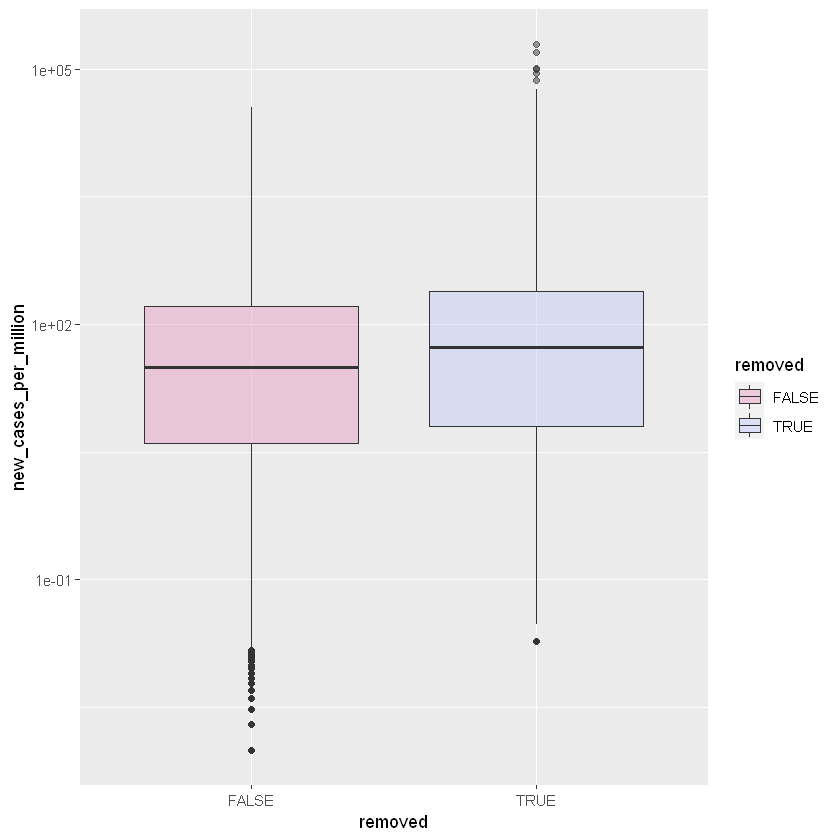

In [39]:
ggplot(bias_check_table, aes(x = removed, y = new_cases_per_million, fill = removed)) + 
    geom_boxplot(alpha = 0.5) + # create a boxplot of new_cases_per_million grouped by removed status
    scale_y_log10() + # scale the y-axis with base-10 logarithmic
    scale_fill_manual(values = c("#E6A0C4", "#C6CDF7"))

Create summaries of `new_cases_per_million` for the two groups.

In [40]:
tapply(bias_check_table$new_cases_per_million, bias_check_table$removed, summary) # create summaries of new_cases_per_million

$`FALSE`
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
    0.00     0.23    11.14   172.32   107.34 35195.42      585 

$`TRUE`
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
     0.00      0.00      0.89    217.74     72.01 195005.31      8565 


Although the median of removed group is lower than the non-removed group, overall they seem comparable in terms of `new_cases_per_million`.

### 1.5.2 GDP per capita<a name="p1.5.2"></a>

We will also perform the same comparison for  `gdp_per_capita`.<br>
First, reduce `bias_check_table` to one row per country since `gdp_per_capita` is a fixed data.

In [41]:
bias_check_table_fixed <-
    bias_check_table %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) # slice one row per group

Then create a boxplot to compare `gdp_per_capita` between countries that were removed and not removed.

Warning message:
"Removed 35 rows containing non-finite values (stat_boxplot)."


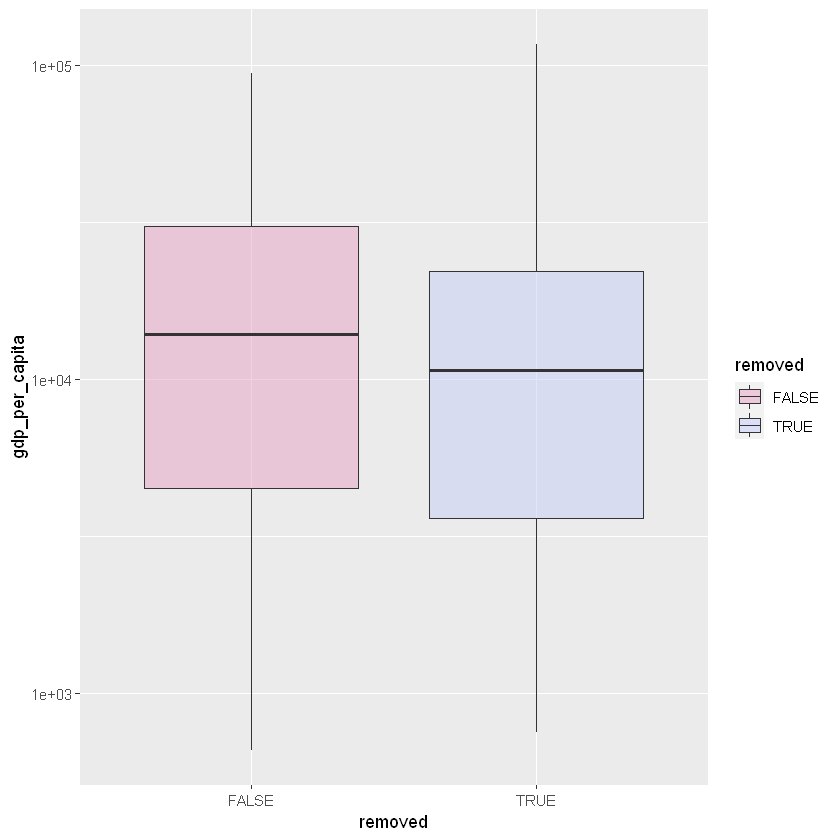

In [42]:
bias_check_table_fixed %>%
    ggplot(aes(x = removed, y = gdp_per_capita, fill = removed)) + 
    geom_boxplot(alpha = 0.5) + # create a boxplot of new_cases_per_million grouped by removed status
    scale_y_log10() + # scale the y-axis with base-10 logarithmic
    scale_fill_manual(values = c("#E6A0C4", "#C6CDF7"))

Also create a summary of `gdp_per_capita` for the two groups.

In [43]:
tapply(bias_check_table_fixed$gdp_per_capita, bias_check_table_fixed$removed, summary) # create summaries of gdp_per_capita

$`FALSE`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  661.2  4504.1 13913.8 19771.6 30778.0 94278.0 

$`TRUE`
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
   752.8   3610.1  10727.1  18321.9  22047.9 116935.6       35 


The removed group has slightly lower `gdp_per_capita` in both mean and median.

### 1.5.3 Population<a name="p1.5.3"></a>

Create a boxplot to compare `population` between countries that were removed and not removed.

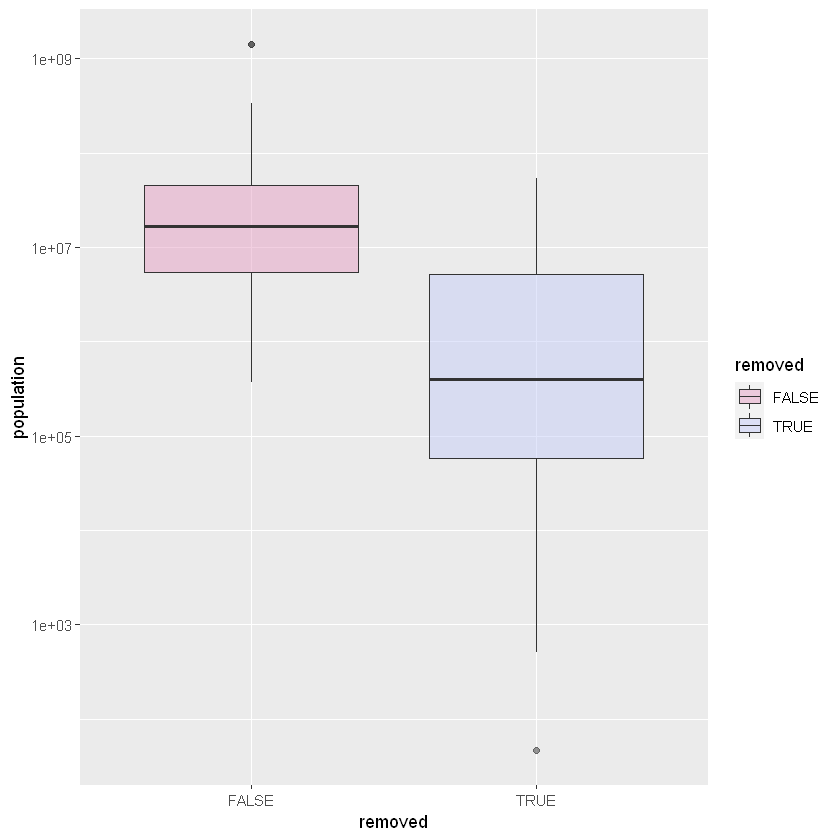

In [44]:
ggplot(bias_check_table_fixed, aes(x = removed, y = population, fill = removed)) + 
    geom_boxplot(alpha = 0.5) + # create a boxplot of population grouped by removed status
    scale_y_log10() + # scale the y-axis with base-10 logarithmic
    scale_fill_manual(values = c("#E6A0C4", "#C6CDF7"))

Create summaries of `population` for the two groups.

In [45]:
tapply(bias_check_table_fixed$population, bias_check_table_fixed$removed, summary) # create summaries of population

$`FALSE`
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
3.703e+05 5.455e+06 1.688e+07 6.036e+07 4.547e+07 1.426e+09 

$`TRUE`
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
      47    57948   403968  4554543  5148816 53798084 


The removed group has significantly lower `population` compared to the non-removed group.<br>
From the three comparisons above we can say that the mergning and cleaning steps of the data have introduced a sampling bias to under-represent countries with smaller populations and slightly lower GDP per capita.

# Part 2: Data Exploration<a name="p2"></a>

In this section we will explore the data from `final_df` to understand them further.<br>
First we will inspect the data types of each variables.

In [46]:
data.frame(sapply(final_df, typeof)) # create a dataframe showing data type of each variables

,sapply.final_df..typeof.
,<chr>
iso_code,character
continent,character
location,character
date,double
month,character
total_cases,double
new_cases,double
new_cases_smoothed,double
total_cases_per_million,double


Data types are correct for all variables.<br>
We will also display the distribution of `double` type variables except for `date`.

In [47]:
summary(final_df[, 6:24]) # Display the distrubution of columns 6-24

  total_cases         new_cases       new_cases_smoothed
 Min.   :       1   Min.   :      0   Min.   :     0.0  
 1st Qu.:   22796   1st Qu.:      6   1st Qu.:    34.4  
 Median :  169396   Median :    220   Median :   331.0  
 Mean   : 1866273   Mean   :   5175   Mean   :  5157.5  
 3rd Qu.:  958772   3rd Qu.:   1760   3rd Qu.:  2016.3  
 Max.   :97023267   Max.   :1355210   Max.   :806874.4  
 total_cases_per_million new_cases_per_million new_cases_smoothed_per_million
 Min.   :     0.1        Min.   :    0.00      Min.   :    0.00              
 1st Qu.:  1492.5        1st Qu.:    0.32      1st Qu.:    2.17              
 Median : 10810.8        Median :   12.60      Median :   22.20              
 Mean   : 59179.5        Mean   :  178.04      Mean   :  177.55              
 3rd Qu.: 71598.5        3rd Qu.:  114.67      3rd Qu.:  140.46              
 Max.   :662430.1        Max.   :35195.42      Max.   :10968.16              
 stringency_index population_density   median_age    ag

## 2.1 Time series data<a name="p2.1"></a>

In this part we will visualise the time series data to explore them.<br>
Visualise `total_cases` for randomly selected sample countries.

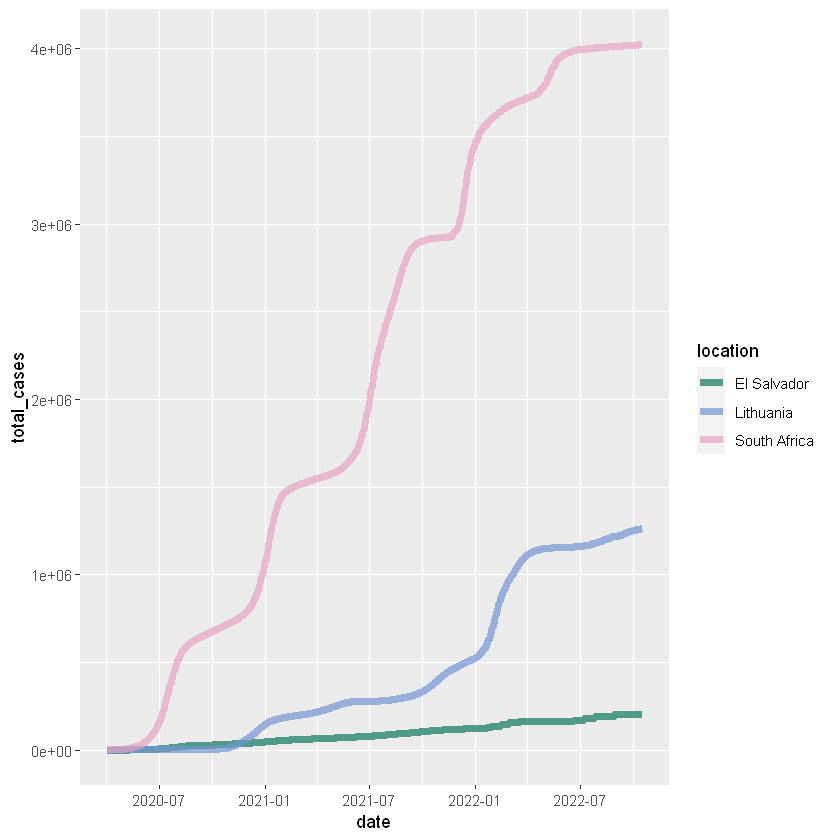

In [48]:
final_df %>%
    filter(iso_code %in% sample(unique(iso_code), 3, replace = FALSE)) %>% # select three iso codes without replacement and filter final_df
    ggplot(aes(x = date, y = total_cases, color = location)) + 
    geom_line(size = 2, alpha = 0.7) + # create a lineplot of total_cases grouped by country
    scale_color_manual(values = c("#0C775F", "#7294D4", "#E6A0C4"))

`total_cases` shows the total confirmed cases of COVID-19 per country.<br>
Since this data is cumulative, it is expected that values increase as time passes at rates depending on `new_cases`.

Visualise `new_cases` for randomly selected sample countries.

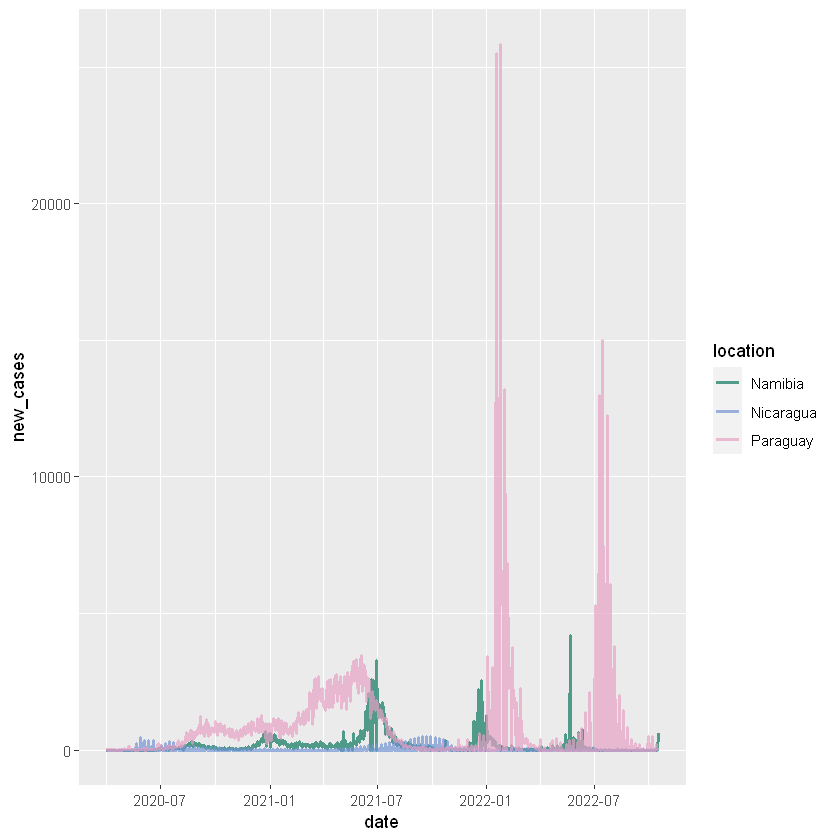

In [49]:
final_df %>%
    filter(iso_code %in% sample(unique(iso_code), 3, replace = FALSE)) %>% # select three iso codes without replacement and filter final_df
    ggplot(aes(x = date, y = new_cases, color = location)) +
    geom_line(size = 1, alpha = 0.7) + # create a lineplot of new_cases grouped by country
    scale_color_manual(values = c("#0C775F", "#7294D4", "#E6A0C4"))

`new_cases`shows the new confirmed cases of COVID-19 per country.<br>
We can see that each country has several peaks in cases over the timeline.

Visualise `new_cases_smoothed` for ramdomly selected sample countries.

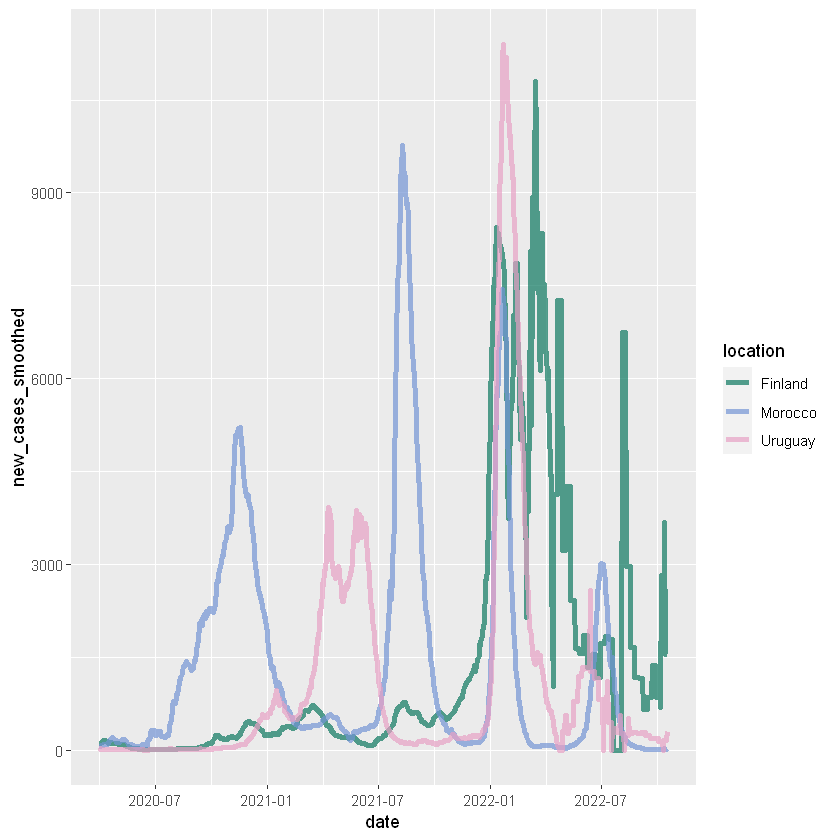

In [50]:
final_df %>%
    filter(iso_code %in% sample(unique(iso_code), 3, replace = FALSE)) %>% # select three iso codes without replacement and filter final_df
    ggplot(aes(x = date, y = new_cases_smoothed, color = location)) +
    geom_line(size = 1.5, alpha = 0.7) + # create a lineplot of new_cases_smoothed grouped by country
    scale_color_manual(values = c("#0C775F", "#7294D4", "#E6A0C4"))

`new_cases_smoothed` shows the new confirmed cases of COVID-19 (7-day smoothed).<br>
Even with outliers removed we can still see the pattern of several peaks in cases over the timeline.

Visualise `total_cases_per_million` for randomly selected sample countries.

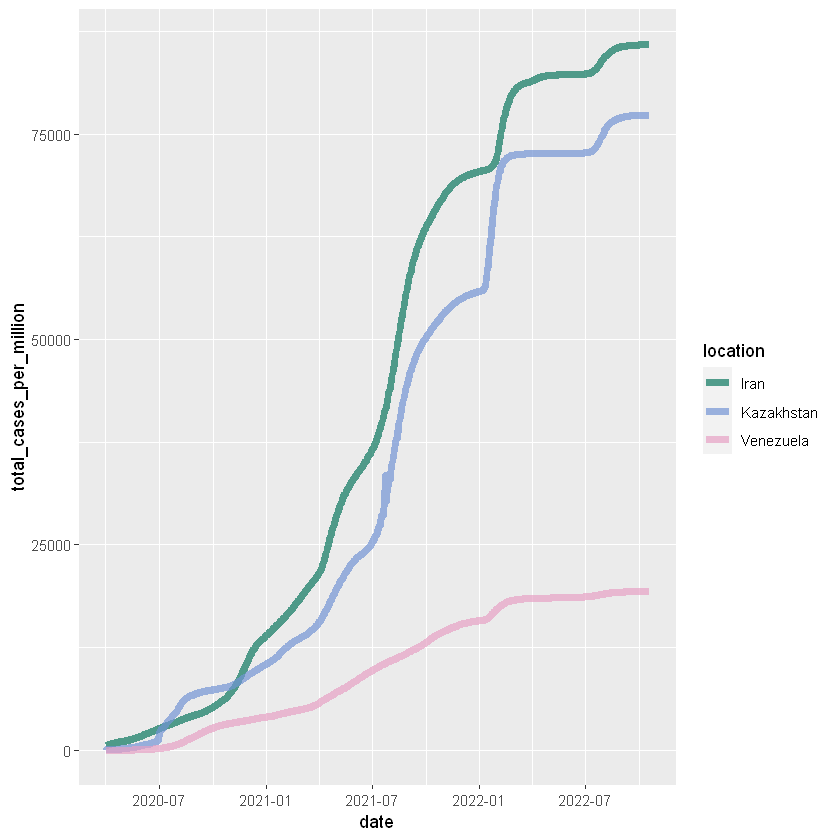

In [51]:
final_df %>%
    filter(iso_code %in% sample(unique(iso_code), 3, replace = FALSE)) %>% # select three iso codes without replacement and filter final_df
    ggplot(aes(x = date, y = total_cases_per_million, color = location)) +
    geom_line(size = 2, alpha = 0.7) + # create a lineplot of total_cases_per_million grouped by country
    scale_color_manual(values = c("#0C775F", "#7294D4", "#E6A0C4"))

`total_cases_per_million` shows the total confirmed cases of COVID-19 per 1,000,000 people.<br>
Similar to `total_cases` this is cumulative, but with the data adjusted for population we can see that some countries have low confirmed cases compared to others overall.

Visualise `new_cases_per_million` for randomly selected sample countries.

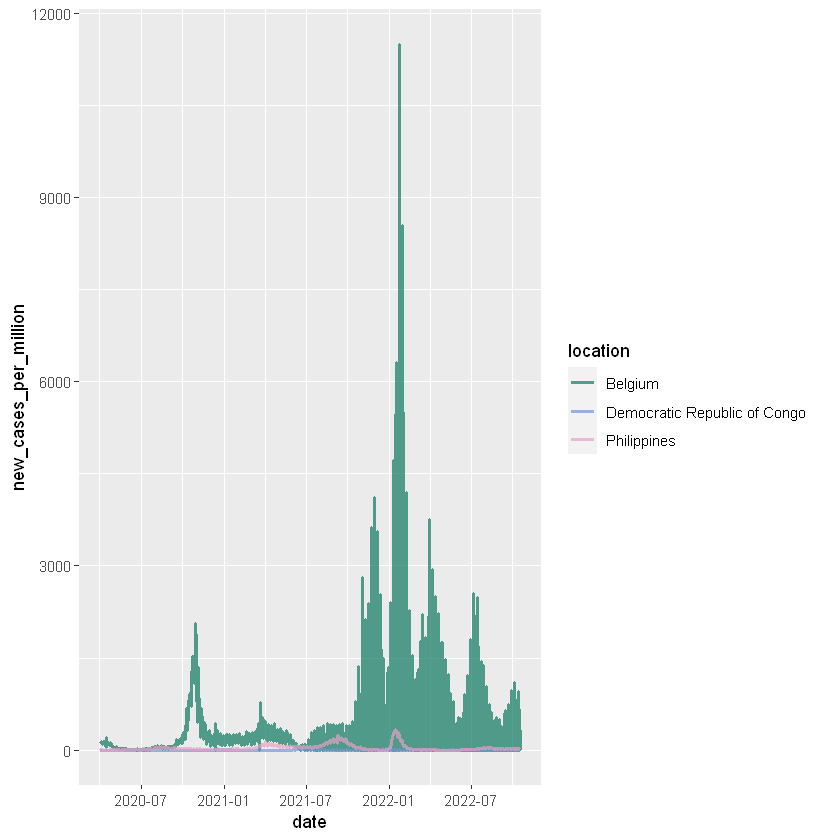

In [52]:
final_df %>%
    filter(iso_code %in% sample(unique(iso_code), 3, replace = FALSE)) %>% # select three iso codes without replacement and filter final_df
    ggplot(aes(x = date, y = new_cases_per_million, color = location)) +
    geom_line(size = 1, alpha = 0.7) + # create a lineplot of new_cases_per_million grouped by country
    scale_color_manual(values = c("#0C775F", "#7294D4", "#E6A0C4"))

`new_cases_per_million` shows the new confirmed cases of COVID-19 per 1,000,000 people.<br>
With the data adjusted for population, we can see the difference in size of the peaks in cases reported.

Visualise `new_cases_smoothed_per_million` for randomly selected sample countries.

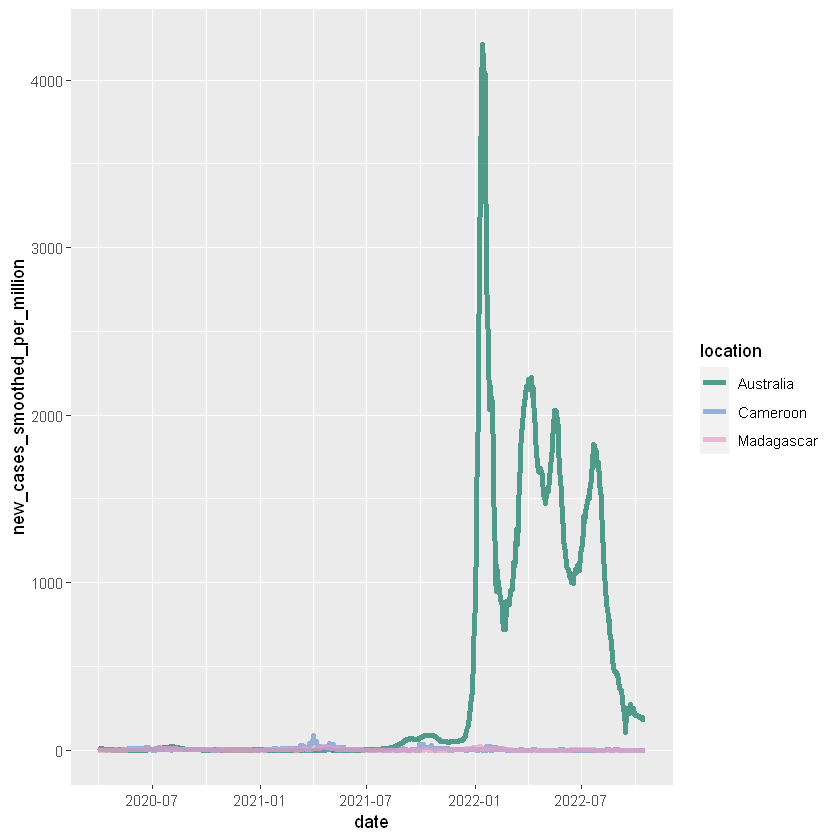

In [53]:
final_df %>%
    filter(iso_code %in% sample(unique(iso_code), 3, replace = FALSE)) %>% # select three iso codes without replacement and filter final_df
    ggplot(aes(x = date, y = new_cases_smoothed_per_million, color = location)) +
    geom_line(size = 1.5, alpha = 0.7) + # create a lineplot of new_cases_smoothed_per_million grouped by country
    scale_color_manual(values = c("#0C775F", "#7294D4", "#E6A0C4"))

`new_cases_smoothed_per_million` shows new confirmed cases of COVID-19 (7-day smoothed) per 1,000,000 people.<br>
Similar to `new_cases_per_million` the data adjusted for population shows the difference in size of the peaks in cases reported.

Visualise `stringency_index` for randomly selected sample countries.

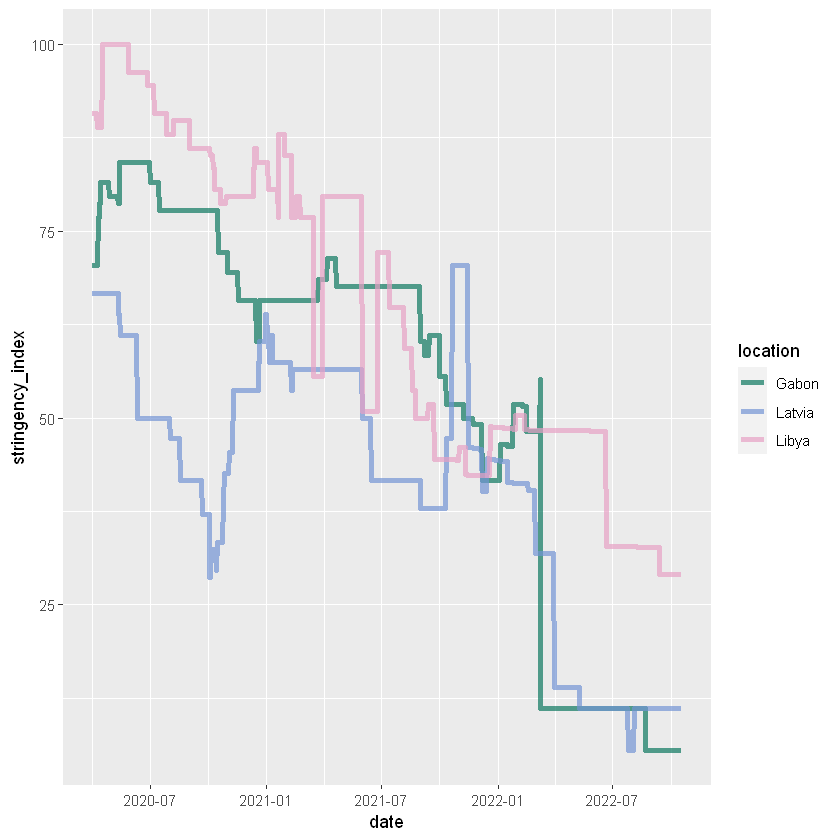

In [54]:
final_df %>%
    filter(iso_code %in% sample(unique(iso_code), 3, replace = FALSE)) %>% # select three iso codes without replacement and filter final_df
    ggplot(aes(x = date, y = stringency_index, color = location)) +
    geom_line(size = 1.5, alpha = 0.7) + # create a lineplot of stringency_index grouped by country
    scale_color_manual(values = c("#0C775F", "#7294D4", "#E6A0C4"))

`stringency_index` shows the Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response).<br>
We can see a general decrease in most countries over the timeline.

Visualise the distribution of `sunshine_hours_month` for randomly selected sample countries.

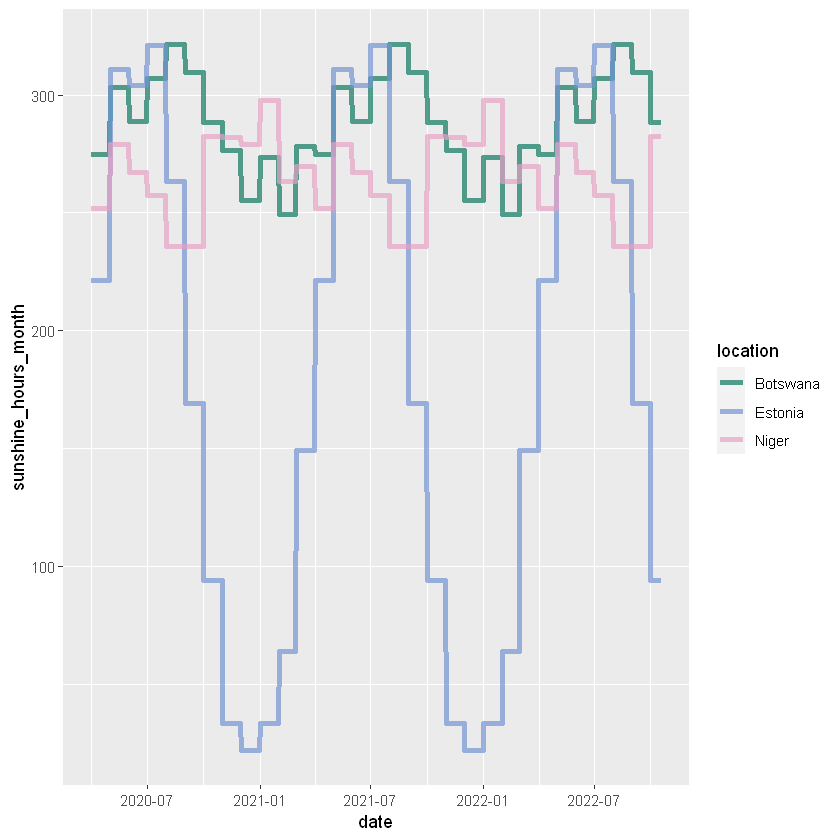

In [55]:
final_df %>%
    filter(iso_code %in% sample(unique(iso_code), 3, replace = FALSE)) %>% # select three iso codes without replacement and filter final_df
    ggplot(aes(x = date, y = sunshine_hours_month, color = location)) +
    geom_line(size = 1.5, alpha = 0.7) +  # create a lineplot of sunshine_hours_month grouped by country
    scale_color_manual(values = c("#0C775F", "#7294D4", "#E6A0C4"))

`sunshine_hours_month` shows the average measured duration of sunshine per month.<br>
Since the data repeats every year, the plot shows clear repeating patters for each countries over the timeline.

## 2.2 Fixed data<a name="p2.2"></a>

In this part we will visualise the fixed data to explore them.<br>
Visualise the distribution of `population_density`.

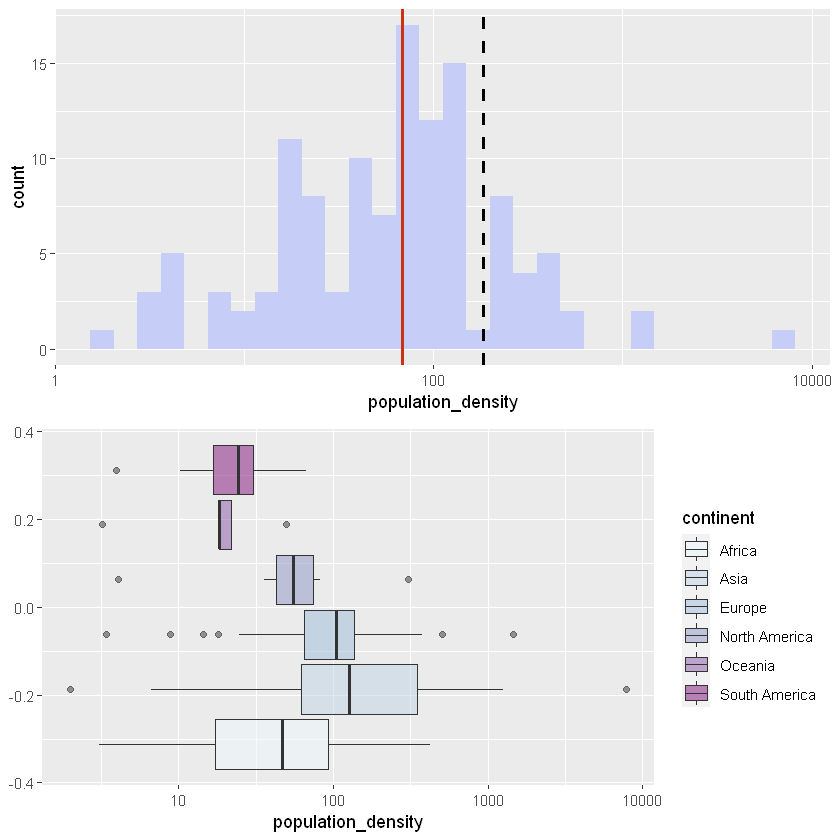

In [56]:
population_density1 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = population_density)) +
    geom_histogram(bins = 30, fill = "#C6CDF7") + # create a histogram of population_density
    scale_x_log10() + # scale the x-axis with base-10 logarithmic
    geom_vline(xintercept = mean(final_df$population_density), size = 1, linetype = "dashed") + # draw a dashed line at mean
    geom_vline(xintercept = median(final_df$population_density), size = 1, colour = "#C93312") # draw a red line at median

population_density2 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = population_density, fill = continent)) +
    geom_boxplot(alpha = 0.5) + # create a boxplot of population_density grouped by continent
    scale_fill_brewer(palette="BuPu") +
    scale_x_log10() # scale the x-axis with base-10 logarithmic
    
grid.arrange(population_density1, population_density2, nrow = 2) # Display two plots in two rows

`population_density` has a unimodal distribution with right skew.<br>
Since there are high outliers, median is more represenative compared to mean.<br>
Asia has the highest, Oceania has the lowest number of people divided by land area, measured in square kilometers.

Visualise the distribution of `median_age`.

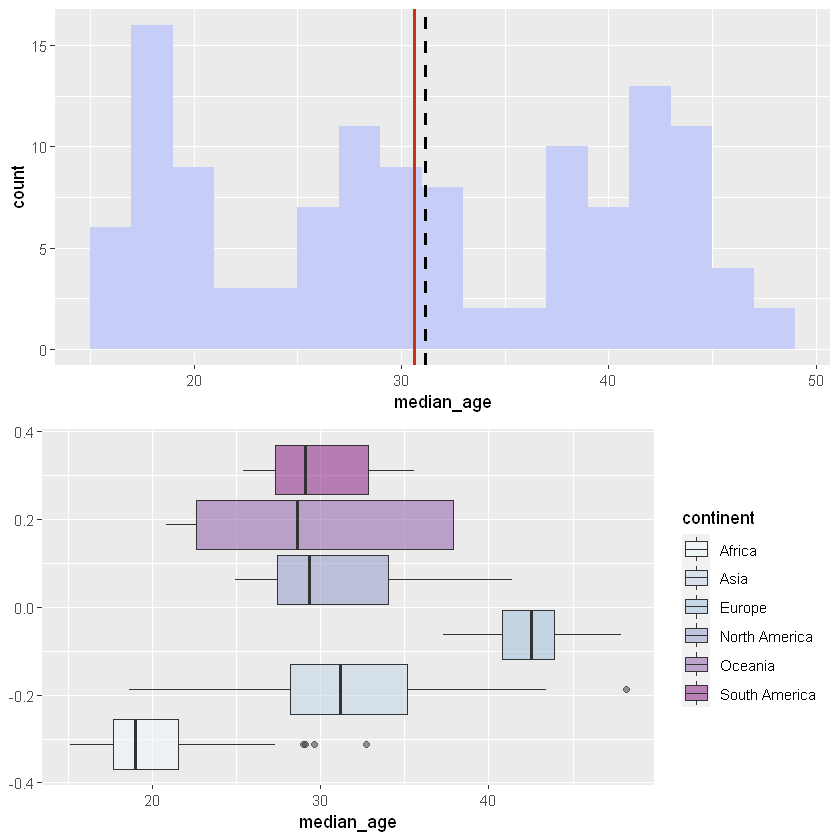

In [57]:
median_age1 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = median_age)) +
    geom_histogram(binwidth = 2, fill = "#C6CDF7") + # create a histogram of median_age
    geom_vline(xintercept = mean(final_df$median_age), size = 1, linetype = "dashed") + # draw a dashed line at mean
    geom_vline(xintercept = median(final_df$median_age), size = 1, colour = "#C93312") # draw a red line at median

median_age2 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = median_age, fill = continent)) +
    geom_boxplot(alpha = 0.5) + # create a boxplot of median_age grouped by continent
    scale_fill_brewer(palette="BuPu")

grid.arrange(median_age1, median_age2, nrow = 2) # Display two plots in two rows

`median_age` has a multimodal distribution.<br>
There are no extreme outliers and median and mean are both likely representative.<br>
North America has the highest, Africa has the lowest median age of the population.

Visualise the distribution of `aged_65_older`.

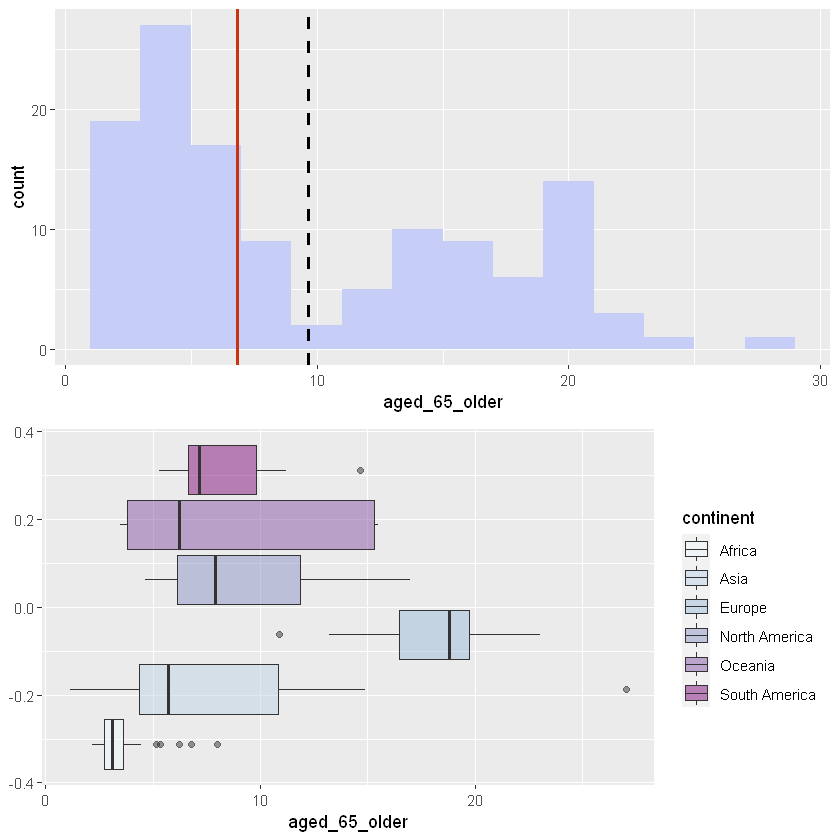

In [58]:
aged_65_older1 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = aged_65_older)) +
    geom_histogram(binwidth = 2, fill = "#C6CDF7") + # create a histogram of aged_65_older
    geom_vline(xintercept = mean(final_df$aged_65_older), size = 1, linetype = "dashed") + # draw a dashed line at mean
    geom_vline(xintercept = median(final_df$aged_65_older), size = 1, colour = "#C93312") # draw a red line at median

aged_65_older2 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = aged_65_older, fill = continent)) +
    geom_boxplot(alpha = 0.5) + # create a boxplot of aged_65_older grouped by continent
    scale_fill_brewer(palette="BuPu")

grid.arrange(aged_65_older1, aged_65_older2, nrow = 2) # Display two plots in two rows

`aged_65_older` has a unimodal distribution with right skew.<br>
There are high outliers, median is more represenative compared to mean.<br>
Europe has the highest, Africa has the lowest share of the population that is 65 years and older.

Visualise the distribution of `aged_70_older`.

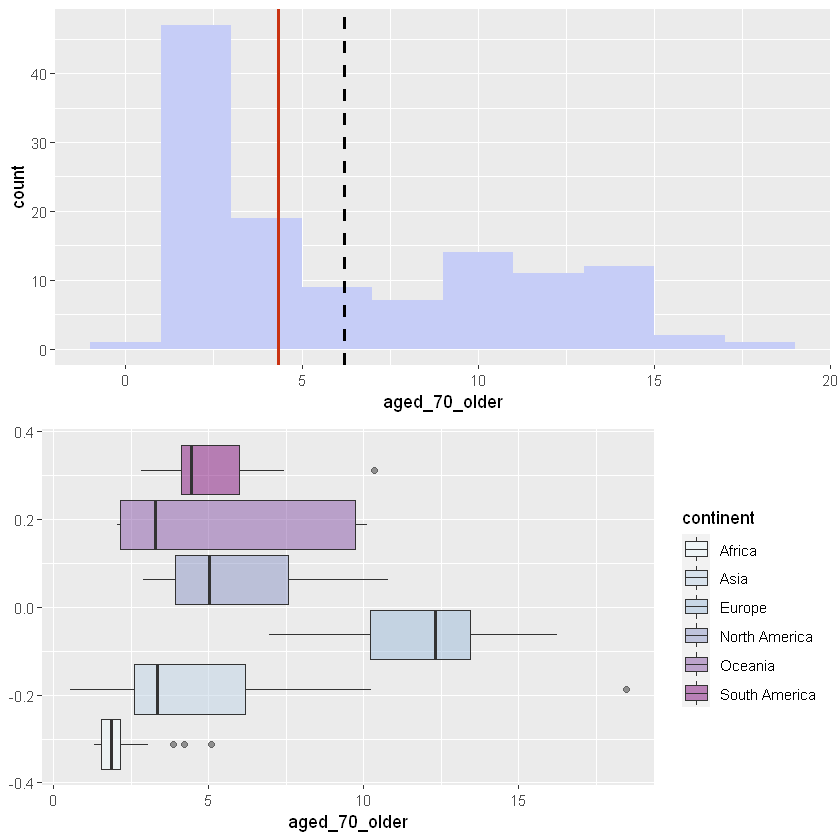

In [59]:
aged_70_older1 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = aged_70_older)) +
    geom_histogram(binwidth = 2, fill = "#C6CDF7") + # create a histogram of aged_70_older
    geom_vline(xintercept = mean(final_df$aged_70_older), size = 1, linetype = "dashed") + # draw a dashed line at mean
    geom_vline(xintercept = median(final_df$aged_70_older), size = 1, colour = "#C93312") # draw a red line at median

aged_70_older2 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = aged_70_older, fill = continent)) +
    geom_boxplot(alpha = 0.5) + # create a boxplot of aged_70_older grouped by continent
    scale_fill_brewer(palette="BuPu")

grid.arrange(aged_70_older1, aged_70_older2, nrow = 2) # Display two plots in two rows

`aged_70_older` has a unimodal distribution with right skew.<br>
Since there are high outliers, median is more represenative compared to mean.<br>
Europe has the highest, Africa has the lowest share of the population that is 70 years and older.

Visualise the distribution of `gdp_per_capita`.

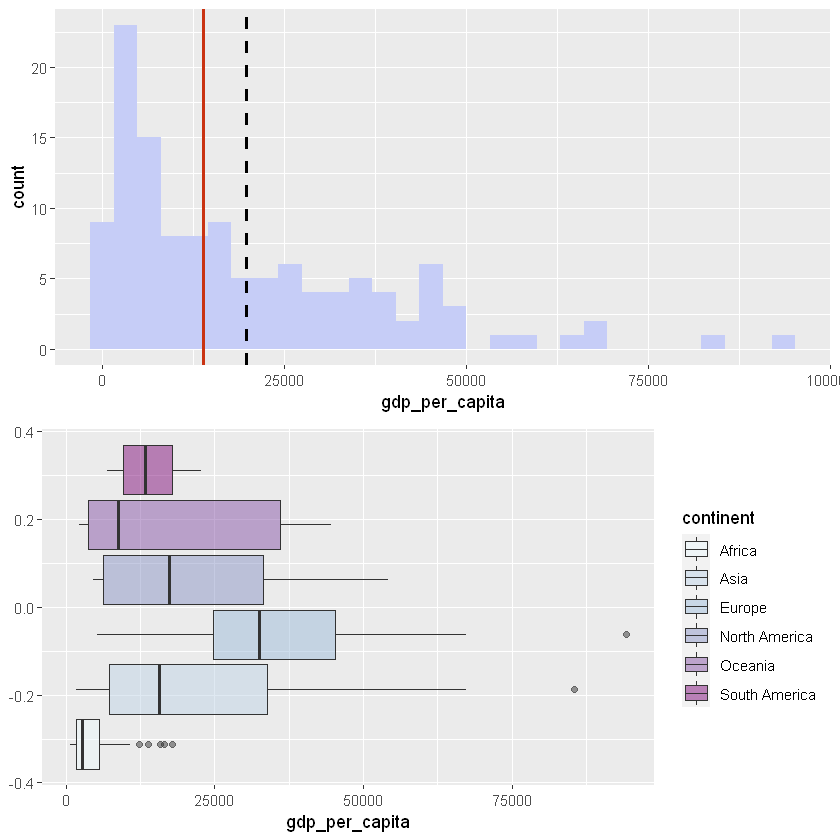

In [60]:
gdp_per_capita1 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = gdp_per_capita)) +
    geom_histogram(bins = 30, fill = "#C6CDF7") + # create a histogram of gdp_per_capital
    geom_vline(xintercept = mean(final_df$gdp_per_capita), size = 1, linetype = "dashed") + # draw a dashed line at mean
    geom_vline(xintercept = median(final_df$gdp_per_capita), size = 1, colour = "#C93312") # draw a red line at median

gdp_per_capita2 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = gdp_per_capita, fill = continent)) +
    geom_boxplot(alpha = 0.5) + # create a boxplot of gdp_per_capita grouped by continent
    scale_fill_brewer(palette="BuPu")

grid.arrange(gdp_per_capita1, gdp_per_capita2, nrow = 2) # Display two plots in two rows

`gdp_per_capita` has a unimodal distribution with right skew.<br>
Since there are high outliers, median is more represenative compared to mean.<br>
Europe has the highest, Africa has the lowest gross domestic product at purchasing power parity.

Visualise the distribution of `cardiovasc_death_rate`.

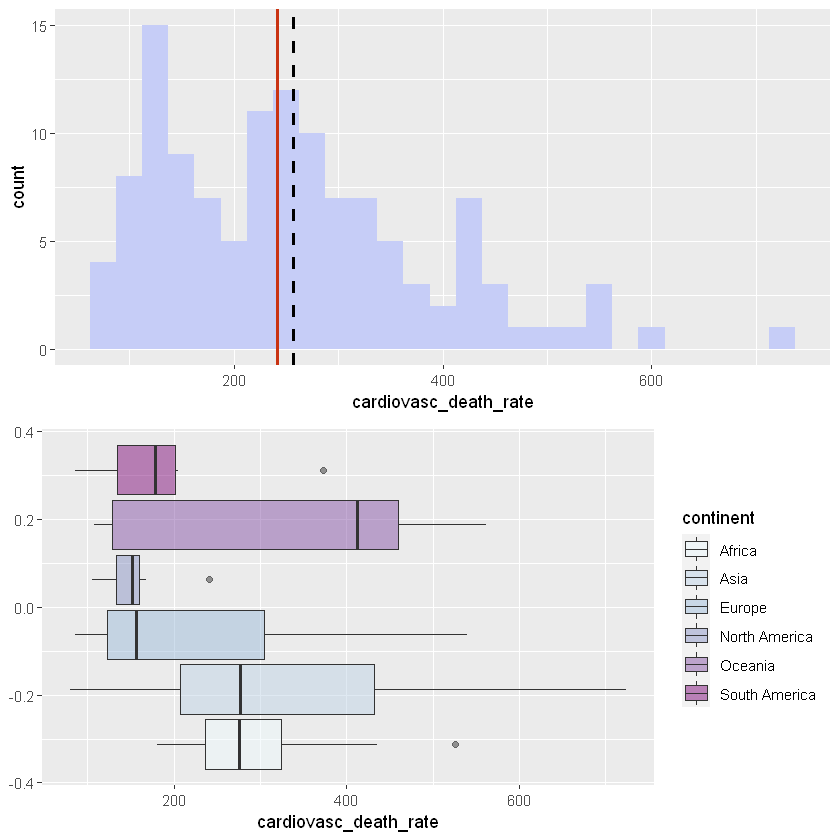

In [61]:
cardiovasc_death_rate1 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = cardiovasc_death_rate)) +
    geom_histogram(binwidth = 25, fill = "#C6CDF7") + # create a histogram of cardiovasc_death_rate
    geom_vline(xintercept = mean(final_df$cardiovasc_death_rate), size = 1, linetype = "dashed") + # draw a dashed line at mean
    geom_vline(xintercept = median(final_df$cardiovasc_death_rate), size = 1, colour = "#C93312") # draw a red line at median

cardiovasc_death_rate2 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = cardiovasc_death_rate, fill = continent)) +
    geom_boxplot(alpha = 0.5) + # create a boxplot of cardiovasc_death_rate grouped by continent
    scale_fill_brewer(palette="BuPu")

grid.arrange(cardiovasc_death_rate1, cardiovasc_death_rate2, nrow = 2) # Display two plots in two rows

`cardiovasc_death_rate` has a unimodal distribution with right skew.<br>
There are no extreme outliers and median and mean are both likely representative.<br>
Oceania has the highest, North America has the lowest death rate from cardiovascular disease.

Visualise the distribution of `diabetes_prevalence`.

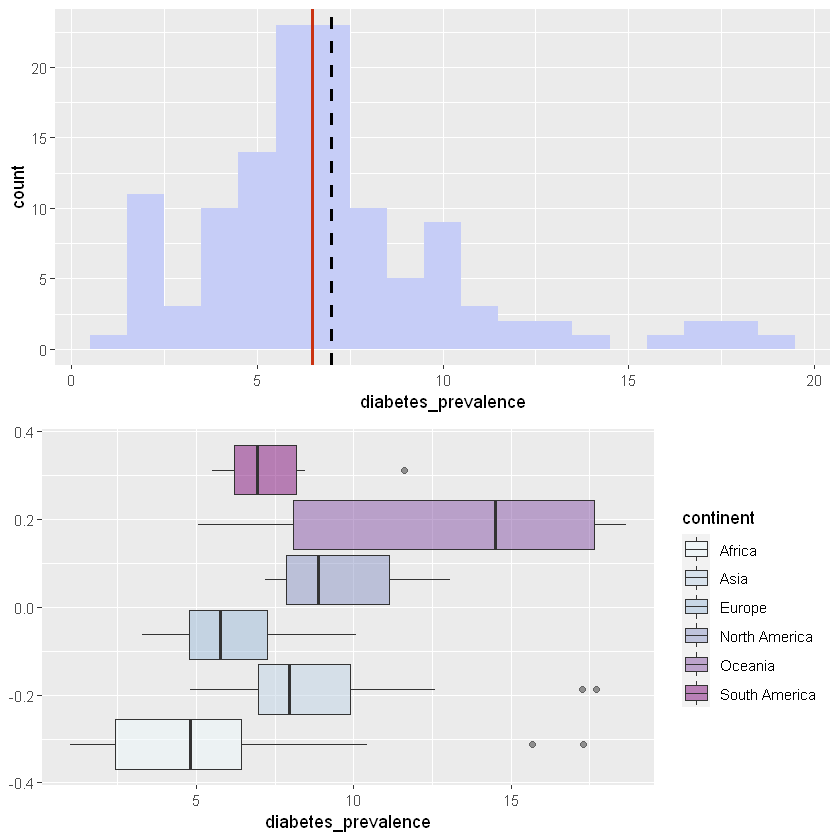

In [62]:
diabetes_prevalence1 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = diabetes_prevalence)) +
    geom_histogram(binwidth = 1, fill = "#C6CDF7") + # create a histogram of diabetes_prevalence
    geom_vline(xintercept = mean(final_df$diabetes_prevalence), size = 1, linetype = "dashed") + # draw a dashed line at mean
    geom_vline(xintercept = median(final_df$diabetes_prevalence), size = 1, colour = "#C93312") # draw a red line at median

diabetes_prevalence2 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = diabetes_prevalence, fill = continent)) +
    geom_boxplot(alpha = 0.5) + # create a boxplot of diabetes_prevalence grouped by continent
    scale_fill_brewer(palette="BuPu")

grid.arrange(diabetes_prevalence1, diabetes_prevalence2, nrow = 2) # Display two plots in two rows

`diabetes_prevalence` has a unimodal distribution with right skew.<br>
There are no extreme outliers and median and mean are both likely representative.<br>
Oceania has the highest, Africa has the lowest diabetes prevalence.

Visualise the distribution of `life_expectancy`.

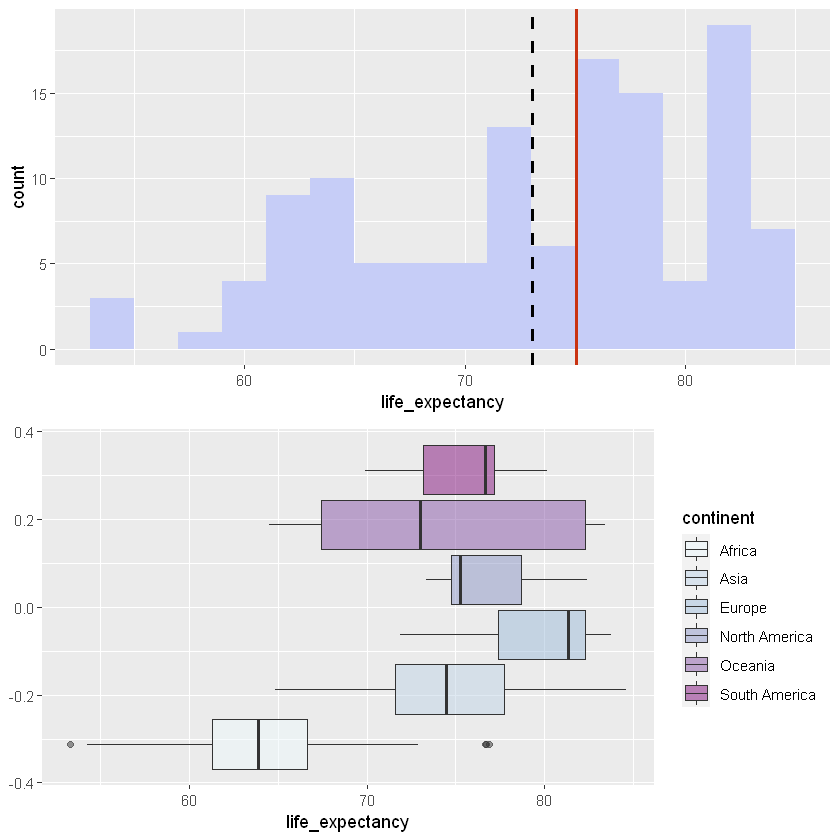

In [63]:
life_expectancy1 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = life_expectancy)) +
    geom_histogram(binwidth = 2, fill = "#C6CDF7") + # create a histogram of life_expectancy
    geom_vline(xintercept = mean(final_df$life_expectancy), size = 1, linetype = "dashed") + # draw a dashed line at mean
    geom_vline(xintercept = median(final_df$life_expectancy), size = 1, colour = "#C93312") # draw a red line at median

life_expectancy2 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = life_expectancy, fill = continent)) +
    geom_boxplot(alpha = 0.5) + # create a boxplot of life_expectancy grouped by continent
    scale_fill_brewer(palette="BuPu")

grid.arrange(life_expectancy1, life_expectancy2, nrow = 2) # Display two plots in two rows

`life_expectancy` has a unimodal distribution with left skew.<br>
Since there are low outliers, median is more represenative compared to mean.<br>
Europe has the highest, Africa has the lowest life expectancy at birth.

Visualise the distribution of `human_development_index`.

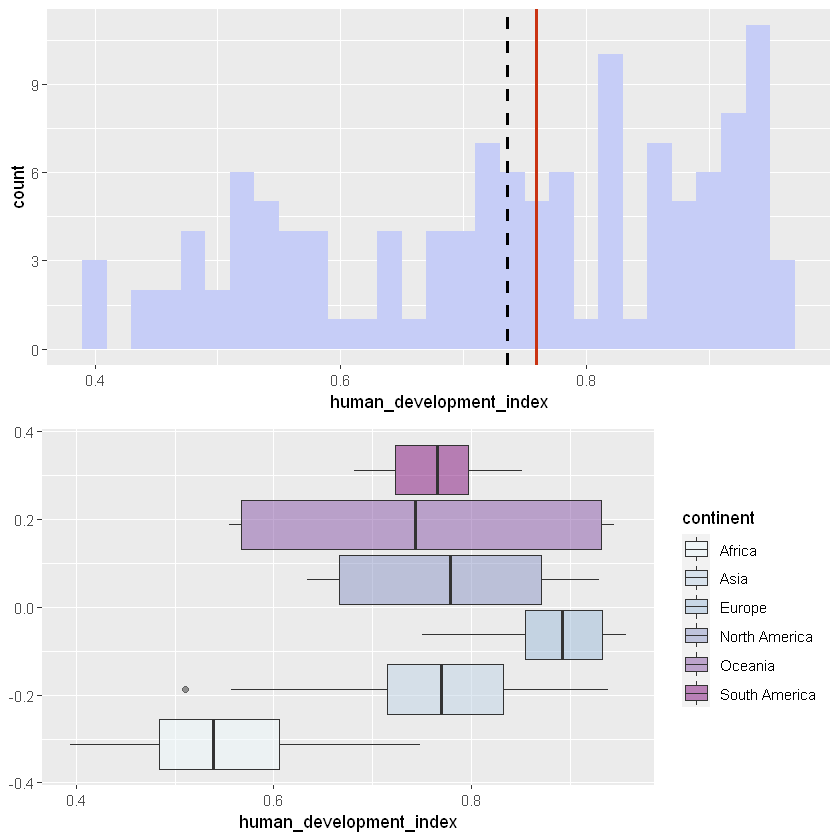

In [64]:
human_development_index1 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = human_development_index)) +
    geom_histogram(binwidth = 0.02, fill = "#C6CDF7") + # create a histogram of human_development_index
    geom_vline(xintercept = mean(final_df$human_development_index), size = 1, linetype = "dashed") + # draw a dashed line at mean
    geom_vline(xintercept = median(final_df$human_development_index), size = 1, colour = "#C93312") # draw a red line at median

human_development_index2 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = human_development_index, fill = continent)) +
    geom_boxplot(alpha = 0.5) + # create a boxplot of human_development_index grouped by continent
    scale_fill_brewer(palette="BuPu")

grid.arrange(human_development_index1, human_development_index2, nrow = 2) # Display two plots in two rows

Human development index is 
><em>a composite index measuring average achievement in three basic dimensions of human development—a long and healthy life, knowledge and a decent standard of living[<sup>3</sup>](#3).</em>

`human_development_index` has a unimodal distribution with left skew.<br>
There are no extreme outliers and median and mean are both likely representative.<br>
Europe has the highest, Africa has the lowest human development index.<br>


Visualise the distribution of `population`.

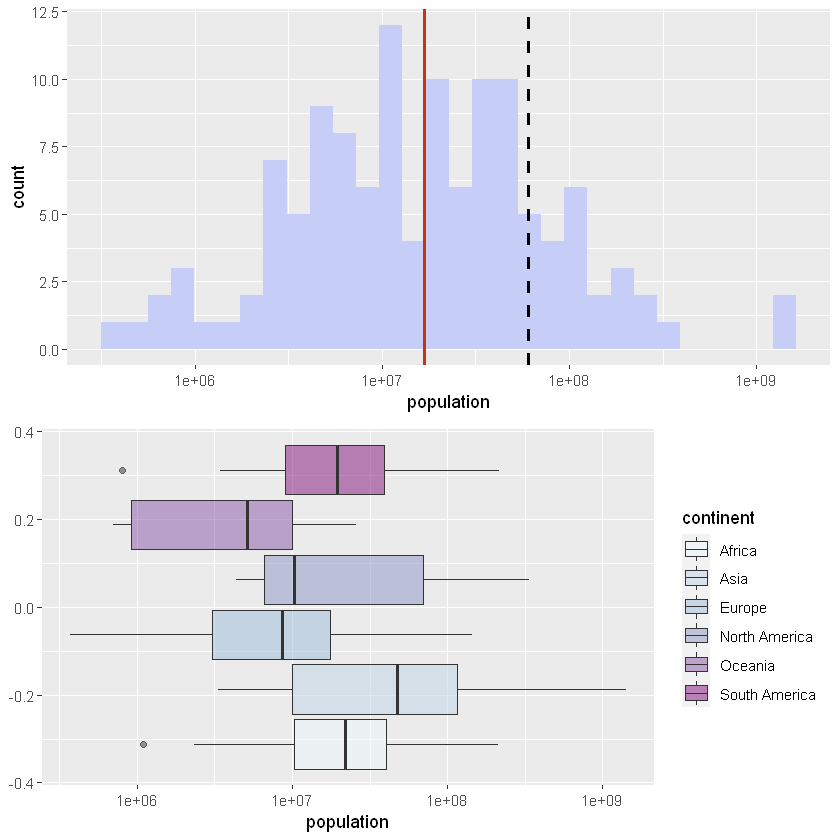

In [65]:
population1 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = population)) +
    geom_histogram(bins = 30, fill = "#C6CDF7") + # create a histogram of population
    scale_x_log10() + # scale the x-axis with base-10 logarithmic
    geom_vline(xintercept = mean(final_df$population), size = 1, linetype = "dashed") + # draw a dashed line at mean
    geom_vline(xintercept = median(final_df$population), size = 1, colour = "#C93312") # draw a red line at median

population2 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = population, fill = continent)) +
    geom_boxplot(alpha = 0.5) + # create a boxplot of population grouped by continent
    scale_fill_brewer(palette="BuPu") +
    scale_x_log10() # scale the x-axis with base-10 logarithmic

grid.arrange(population1, population2, nrow = 2) # Display two plots in two rows

`population` has a unimodal distribution with right skew.<br>
Since there are high outliers, median is more represenative compared to mean.<br>
Asia has the highest, Oceania has the lowest population.

Visualise the distribution of `sunshine_hours_year`.

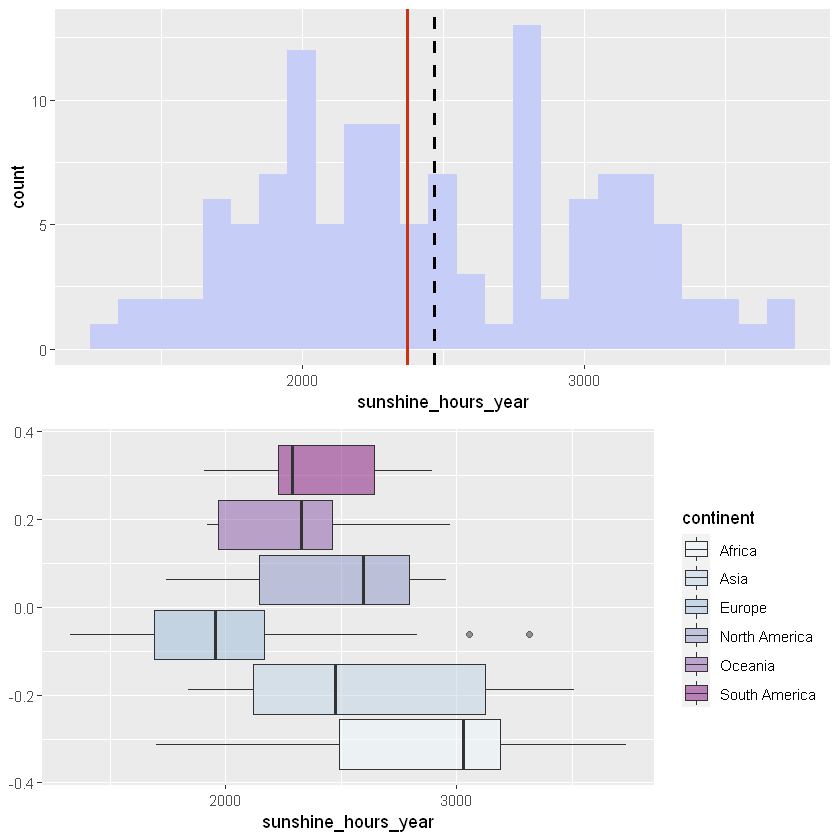

In [66]:
sunshine_hours_year1 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = sunshine_hours_year)) +
    geom_histogram(binwidth = 100, fill = "#C6CDF7") + # create a histogram of sunshine_hours_year
    geom_vline(xintercept = mean(final_df$sunshine_hours_year), size = 1, linetype = "dashed") + # draw a dashed line at mean
    geom_vline(xintercept = median(final_df$sunshine_hours_year), size = 1, colour = "#C93312") # draw a red line at median

sunshine_hours_year2 <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    slice(1) %>% # slice one row per group
    ggplot(aes(x = sunshine_hours_year, fill = continent)) +
    geom_boxplot(alpha = 0.5) + # create a boxplot of sunshine_hours_year grouped by continent
    scale_fill_brewer(palette="BuPu")

grid.arrange(sunshine_hours_year1, sunshine_hours_year2, nrow = 2) # Display two plots in two rows

`sunshine_hours_year` has a multimodal distribution.<br>
There are no extreme outliers and median and mean are both likely representative.<br>
Africa has the highest, Europe has the lowest sunshine duration of sunshine per year.

# Part 3: Drill Down into a Subset of Data<a name="p3"></a>

## 3.1 Rank correlation<a name="p3.1"></a>

#### Question 1: Does the yearly total suneshine duration of a country impact its total number of confirmed cases?

Null hypothesis (H0): The yearly total sunshine duration of a country does not impact its total number of confirmed cases.<br>
Alternative hypothesis (H1): The yearly total sunshine duration of a country impacts its total number of confirmed cases.

We will first filter `final_df` for rows from the latest date `2022-10-18`.

In [67]:
october18 <- 
    final_df %>% 
    filter(date == as.Date("2022-10-18", "%Y-%m-%d")) # filter for data from 2022-10-18

Check the distribution of `total_cases_per_million` from the outcome variable`october18`.

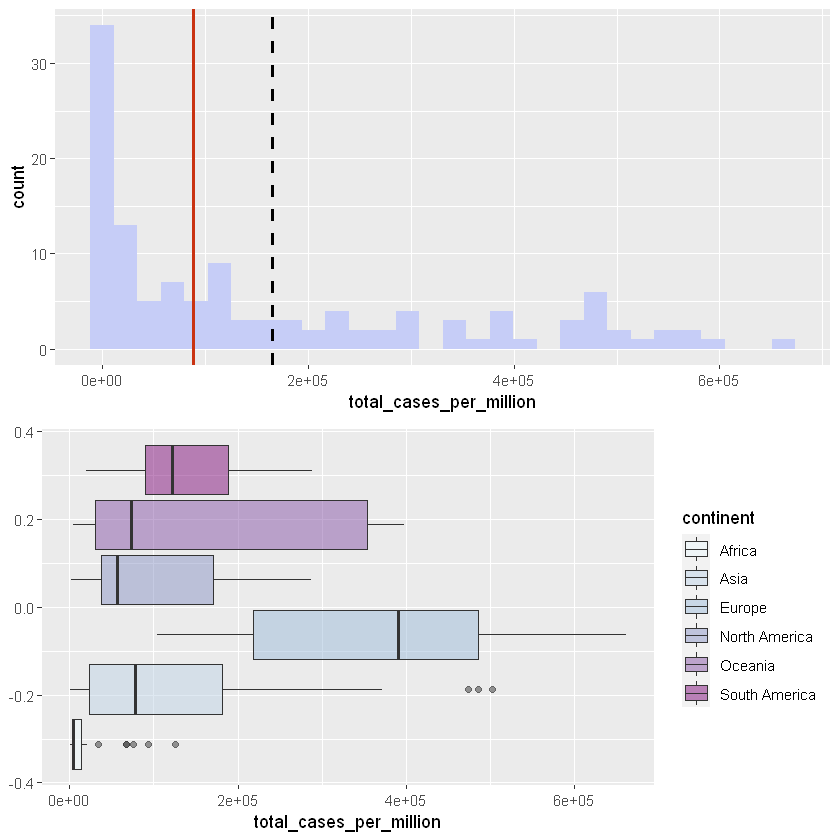

In [68]:
october18_1 <-
    october18 %>%
    ggplot(aes(x = total_cases_per_million)) +
    geom_histogram(bins = 30, fill = "#C6CDF7") + # create a histogram of `total_cases_per_million`
    geom_vline(xintercept = mean(october18$total_cases_per_million), size = 1, linetype = "dashed") + # draw a dashed line at mean
    geom_vline(xintercept = median(october18$total_cases_per_million), size = 1, colour = "#C93312") # draw a red line at median

october18_2 <-
    october18 %>%
    ggplot(aes(x = total_cases_per_million, fill = continent)) +
    geom_boxplot(alpha = 0.5) + # create a boxplot of sunshine_hours_year grouped by continent
    scale_fill_brewer(palette="BuPu")

grid.arrange(october18_1, october18_2, nrow = 2) # Display two plots in two rows

Visualise the relationship between `total_cases_per_million` from `2022-10-18` and `sunshine_hours_year`.<br>

`geom_smooth()` using formula 'y ~ x'



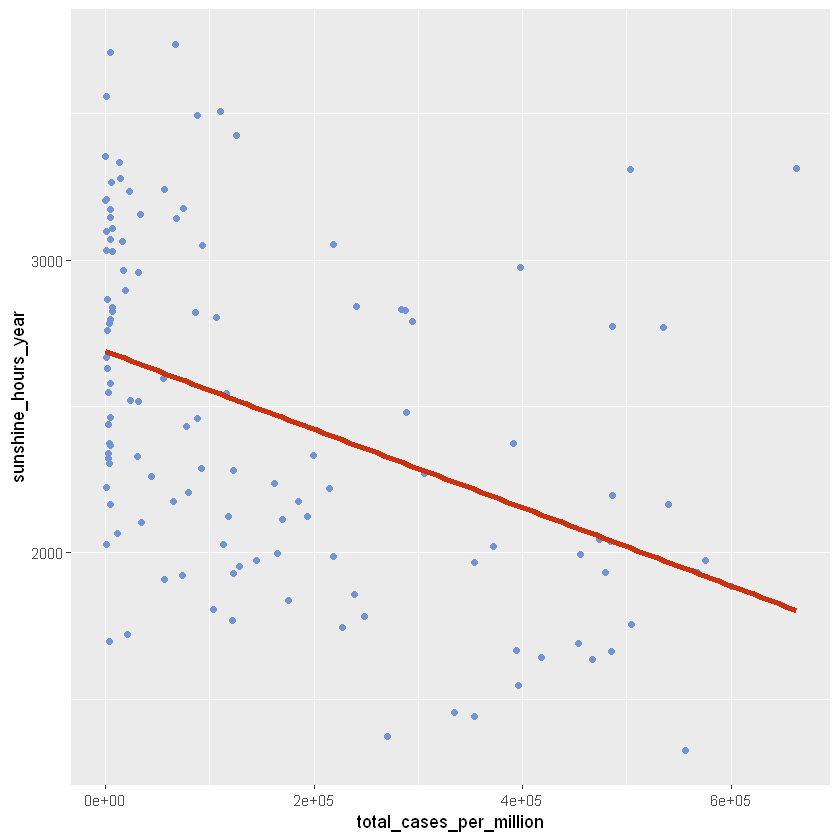

In [69]:
october18 %>%
    ggplot(aes(x = total_cases_per_million, y = sunshine_hours_year)) +
    geom_point(color = "#7294D4") +
    geom_smooth(method = "lm",
                color = "#C93312",
                size = 1.5,
                se = FALSE) 

There appears to be a negative correlation between `sunshine_hours_year` and `total_case_per_million`.<br>
For computing correlation coefficient, we cannot use Pearson’s correlation since `sunshine_hours_year` has a strong skew and not normally distributed.<br>
We will use Kendall and not Spearman since Kendall is more robust.

In [70]:
cor.test(october18$total_cases_per_million, october18$sunshine_hours_year, method = "kendall")


	Kendall's rank correlation tau

data:  october18$total_cases_per_million and october18$sunshine_hours_year
z = -5.3013, p-value = 1.15e-07
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
-0.3232041 


The relationship between `total_cases_per_million` from `2022-10-18` and `sunshine_hours_year` was investigated using Kendall's tau.<br>
Using Cohen’s effect size heuristic[<sup>5</sup>](#5) of small: r = ±.1, medium: r = ±.3, and large: r = ±.5, a medium negative correlation was found (τ = -0.321).<br>
Based on this we will reject the null hypothesis.<br>
There is a medium correlation that the higher the country's yearly total sunshine duration, the lower the total number of confirmed cases.

#### Question 2: Does the average stringency index of a country impact its total number of confirmed cases?

Null hypothesis (H0): The average stringency index of a country does not impact its total number of confirmed cases.
Alternative hypothesis (H1): The average stringency index of a country impacts its total number of confirmed cases.

We will calculate the mean of `stringency_index` for each country and filter for rows from the latest date `2022-10-18`.

In [71]:
october18_mean_stringency <-
    final_df %>%
    group_by(iso_code) %>% # group by iso codes
    mutate(mean_stringency = mean(stringency_index)) %>% # calculate the mean of stringency_index for each iso code
    filter(date == as.Date("2022-10-18", "%Y-%m-%d")) # filter for data from 2022-10-18

Visualise the relationship `between total_cases_per_million` from `2022-10-18` and the mean of stringency index.

`geom_smooth()` using formula 'y ~ x'



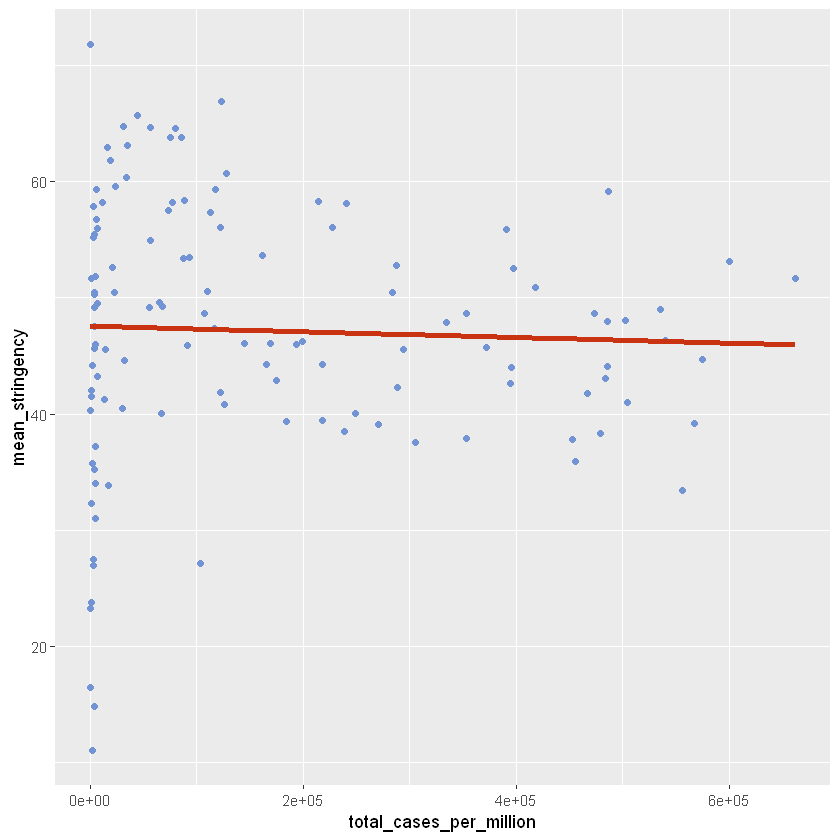

In [72]:
october18_mean_stringency %>%
    ggplot(aes(x = total_cases_per_million, y = mean_stringency)) +
    geom_point(color = "#7294D4") +
    geom_smooth(method = "lm",
                color = "#C93312",
                size = 1.5,
                se = FALSE)

From the correlation between `mean_stringency` and `total_cases_per_million` seem weak. 

In [73]:
cor.test(october18_mean_stringency$total_cases_per_million, october18_mean_stringency$mean_stringency, method = "kendall")


	Kendall's rank correlation tau

data:  october18_mean_stringency$total_cases_per_million and october18_mean_stringency$mean_stringency
z = 0.076513, p-value = 0.939
alternative hypothesis: true tau is not equal to 0
sample estimates:
        tau 
0.004664801 


The relationship between `total_cases_per_million` from `2022-10-18` and `mean_stringency` was investigated using Kendall's tau.<br>
Using Cohen’s effect size heuristic, no significant correlation was found (τ = 0.005).<br>
There is therefore no evidence to reject the null hypothesis.
There is likely to be no meaningful relationship between `total_cases_per_million` from `2022-10-18` and `mean_stringency`.

## 3.2 Time series cross correlation<a name="p3.2"></a>

#### Question 3: Does the montly total suneshine duration of a country impact its monthly COVID cases over the time series?

Null hypothesis (H0): The monthly total sunshine duration of a country does not impact its monthly number of confirmed cases.<br>
Alternative hypothesis (H1): The monthly total sunshine duration of a country impacts its monthly number of confirmed cases.

To answer this question we will look at the cross correlation between sum of `new_cases` each month and `sunshine_hours_month`.<br>
First we will calculate the sum of `new_cases_per_million` per country per month.

In [74]:
monthly_cases_per_million <-
    final_df %>%
    mutate(month = cut(date, breaks = "month")) %>% # create a new column dividing dates into months
    group_by(iso_code, month, sunshine_hours_month) %>% # group by iso codes, months, and "sunshine_hours_month"
    summarise(new_cases_per_million_month = sum(new_cases_per_million), .groups = "keep") # calculate the sum of new_cases_per_million
dim(monthly_cases_per_million) # display the dimension of monthly_cases_per_million
head(monthly_cases_per_million) # check the first few rows

[1] 3807    4

iso_code,month,sunshine_hours_month,new_cases_per_million_month
<chr>,<date>,<dbl>,<dbl>
AFG,2020-04-01,232.5,41.422
AFG,2020-05-01,310.3,332.998
AFG,2020-06-01,353.4,405.615
AFG,2020-07-01,356.8,129.251
AFG,2020-08-01,339.7,40.401
AFG,2020-09-01,303.9,27.581


We will now investigate the relationships between `new_cases_per_million_month` and `sunshine_hours_month` for each country using cross correlation.<br>
We will then save the lag and correlation in a dataframe.

In [75]:
ccf_df <- data.frame(matrix(ncol = 4, nrow = 0)) # create an empty dataframe with four columns

for (iso in unique(monthly_cases_per_million$iso_code)) { # loop though a list of unique iso codes
    filtered_df <- monthly_cases_per_million %>% filter(iso_code == iso) # filter monthly_cases_per_million for the iso code
    ccf <- ccf(ts(filtered_df$new_cases_per_million_month), ts(filtered_df$sunshine_hours_month), pl = FALSE) # put "new_cases_per_million_month" and "sunshine_hours_month" through the sample cross correlation function
    ccf_df_iso <- rbind(ccf_df, data.frame(iso, ccf$lag, ccf$acf)) # create a dataframe of the results and append to ccf_df
    ccf_df <- ccf_df_iso # replace ccf_df with newly appended ccf_df_iso
}

dim(ccf_df) # display the dimension of ccf_df
head(ccf_df) # check the first few rows

[1] 2827    3

,iso,ccf.lag,ccf.acf
,<chr>,<dbl>,<dbl>
1,AFG,-11,0.1866062
2,AFG,-10,-0.1306669
3,AFG,-9,-0.3540958
4,AFG,-8,-0.4643040
5,AFG,-7,-0.4778649
6,AFG,-6,-0.3693476


Filter the results for the maximum absolute correlation per country, and divide them into `high`, `medium`, and `low`.

In [76]:
new_cases_sunshine_correlation <-
    ccf_df %>%
    group_by(iso) %>% # group by iso codes
    slice_max(abs(ccf.acf), n = 1) %>% # slice for the maximum absolute value of "ccf.acf"
    mutate(correlation = 
           if(abs(ccf.acf) >= 0.5) {"high"} # if ccf.acf is higher than or equal to 0.5 then categorise the row as "high"
           else if(abs(ccf.acf) >= 0.3 & abs(ccf.acf) < 0.5) {"medium"} # if ccf.acf is higher than 0.3 then categorise the row as "medium"
           else if(abs(ccf.acf) >= 0.1 & abs(ccf.acf) < 0.3) {"low"} # if ccf.acf is higher than 0.1 then categorise the row as "low"
           else {"none"} # otherwise categorise the row as "none"
           )    
dim(new_cases_sunshine_correlation) # display the dimension of new_cases_sunshine_correlation
head(new_cases_sunshine_correlation) # check the first few rows

[1] 123   4

iso,ccf.lag,ccf.acf,correlation
<chr>,<dbl>,<dbl>,<chr>
AFG,-7,-0.4778649,medium
AGO,-5,0.4119703,medium
ALB,-6,0.5426640,high
ARE,8,0.5446119,high
ARG,2,0.2755819,low
AUS,4,0.3461678,medium


Visualise the categorised correlations grouped by continents.

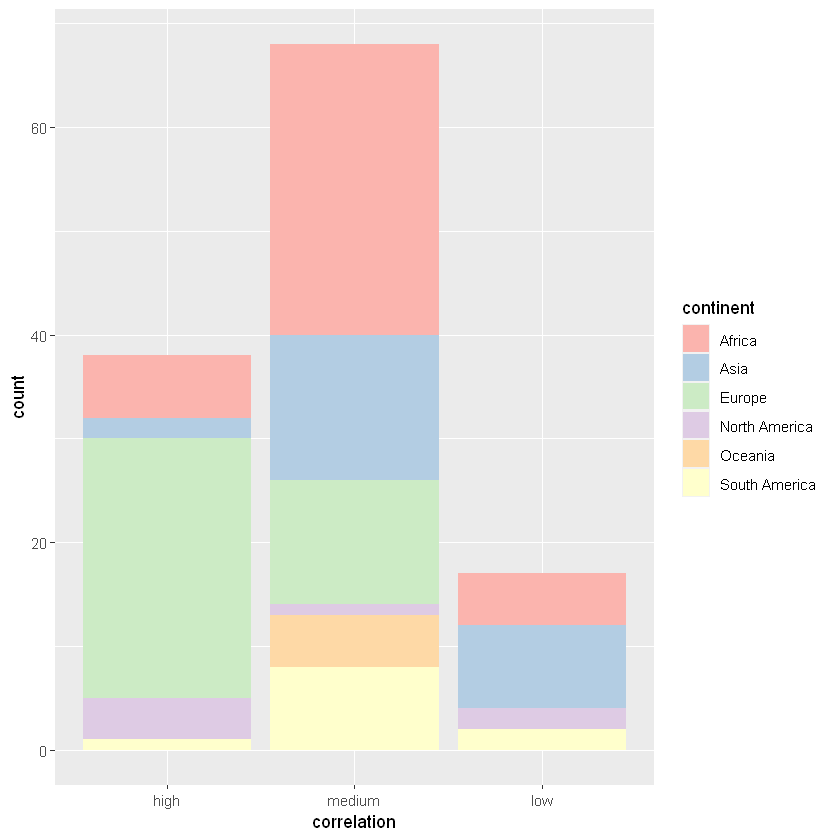

In [77]:
new_cases_sunshine_correlation$correlation <- 
    factor(new_cases_sunshine_correlation$correlation, levels = c("high", "medium", "low", "none")) # set the levels of correlation categories

correlation_table <-
    new_cases_sunshine_correlation %>%
    left_join(final_df[, 1:3], by = c("iso" = "iso_code")) %>% # left join the continents and country names from final_df
    slice(1) # slice one row per group

correlation_table %>%
    ggplot(aes(x = correlation, fill = continent)) +
    geom_bar(position = "stack") + # create a barplot of "correlation" grouped by "continent"
    scale_fill_brewer(palette = "Pastel1")

Also calculate the percentage share of each correlation groups.

In [78]:
correlation_table %>%
    group_by(correlation) %>%
    count(correlation) %>% # count the number of countries in each correlation categories
    mutate(correlation_percentage = round((n / nrow(correlation_table))*100, 2)) # calculate the percentage of the dataset that are in each category

correlation,n,correlation_percentage
<fct>,<int>,<dbl>
high,38,30.89
medium,68,55.28
low,17,13.82


The relationship between `sunshine_hours_month` and `new_cases_per_million_month` was investigated using cross correlation.<br>
Using Cohen’s effect size heuristic, 30.89% of countries have high correlation between `new_cases_per_million_month` and `sunshine_hours_month`, and most of these countries are in Europe. This supports Walrand's report[<sup>1</sup>](#1) of correlation between COVID cases and the amount of sunshine in Europe with data from up to October 2022.<br>
55.28% of countries have medium correlation, with top three continents in this category being Africa, Asia, and Europe.<br>
13.82% of countries have low correlation, most of these countries are in Asia.<br>
None of the countries have less than 0.1 in correlation.<br>
Based on this we will reject the null hypothesis.

Visualise the distribution of the maximum absolute correlation per country.

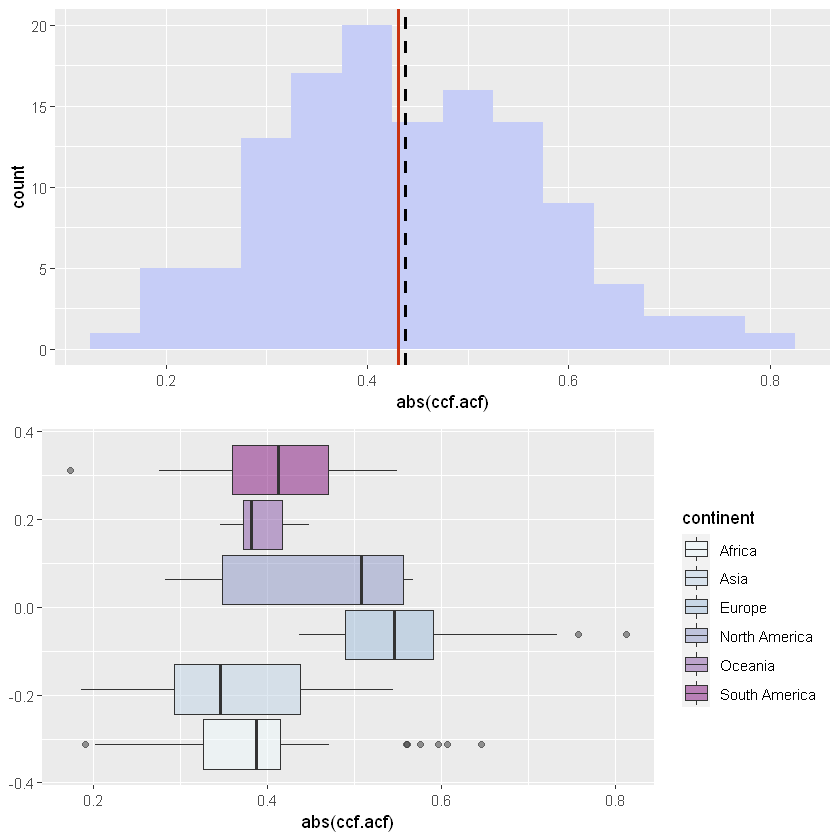

In [79]:
new_cases_sunshine_correlation1 <-
    new_cases_sunshine_correlation %>%
    ggplot(aes(x = abs(ccf.acf))) +
    geom_histogram(binwidth = 0.05, fill = "#C6CDF7") + # create a histogram of sunshine_hours_year
    geom_vline(xintercept = mean(abs(new_cases_sunshine_correlation$ccf.acf)), size = 1, linetype = "dashed") + # draw a dashed line at mean
    geom_vline(xintercept = median(abs(new_cases_sunshine_correlation$ccf.acf)), size = 1, colour = "#C93312") # draw a red line at median

new_cases_sunshine_correlation2 <-
    correlation_table %>%
    ggplot(aes(x = abs(ccf.acf), fill = continent)) +
    geom_boxplot(alpha = 0.5) + # create a boxplot of the maximum absolute correlation per country grouped by continent
    scale_fill_brewer(palette="BuPu")

grid.arrange(new_cases_sunshine_correlation1, new_cases_sunshine_correlation2, nrow = 2) # Display two plots in two rows

The maximum absolute correlation value has a unimodal distribution with slight right skew.<br>
There are no extreme outliers and median and mean are both likely representative.<br>
Europe has the highest median, Asia has the lowest median.

Let's inspect the highest and lowest maximum absolute correlation values.<br>
First we will find which countries have the highest and lowest maximum absolute correlation values.

In [80]:
new_cases_sunshine_correlation %>%
    arrange(desc(abs(ccf.acf))) %>% # arrange the column by absolute correlation values
    head(1) # select the first one row

new_cases_sunshine_correlation %>%
    arrange(desc(abs(ccf.acf))) %>% # arrange the column by absolute correlation values
    tail(1) # select the last one row

iso,ccf.lag,ccf.acf,correlation
<chr>,<dbl>,<dbl>,<fct>
CZE,0,-0.8132144,high


iso,ccf.lag,ccf.acf,correlation
<chr>,<dbl>,<dbl>,<fct>
VEN,0,0.1728714,low


Czech Republic has the highest absolute correlation, and Venezuela has the lowest absolute correlation.<br>
Plot the result of the sample cross correlation function for Czech Republic.

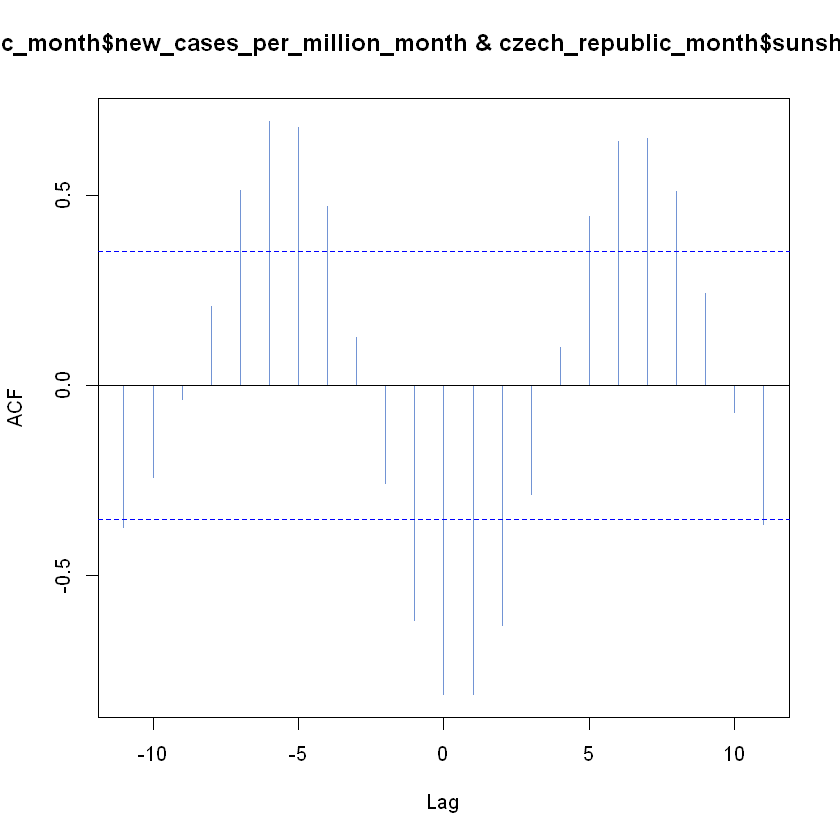

In [81]:
czech_republic_month <-
    monthly_cases_per_million %>%
    filter(iso_code == "CZE") # filter for iso code "CZE"
ccf(czech_republic_month$new_cases_per_million_month, czech_republic_month$sunshine_hours_month, col = "#7294D4") # put "new_cases_per_million_month" and "sunshine_hours_month" through the sample cross correlation function

For Czech Republic, the strongest correlation between `new_cases_per_million_month` and `sunshine_hours_month` is a negative correlation of -0.8132144 at lag 0.<br>
There are also strong positive correlations around lags -6 and 6, showing a seasonal pattern.<br>
We can intuitively assume that decrease in sunshine duration leads to decrease in blood 25-hydroxyvitamin D (25(OH)D) concentration lowering immunity against respiratory tract infections in the population, and as a result new cases increases after 6 months.

Plot the result of the sample cross correlation function for Venezuela.

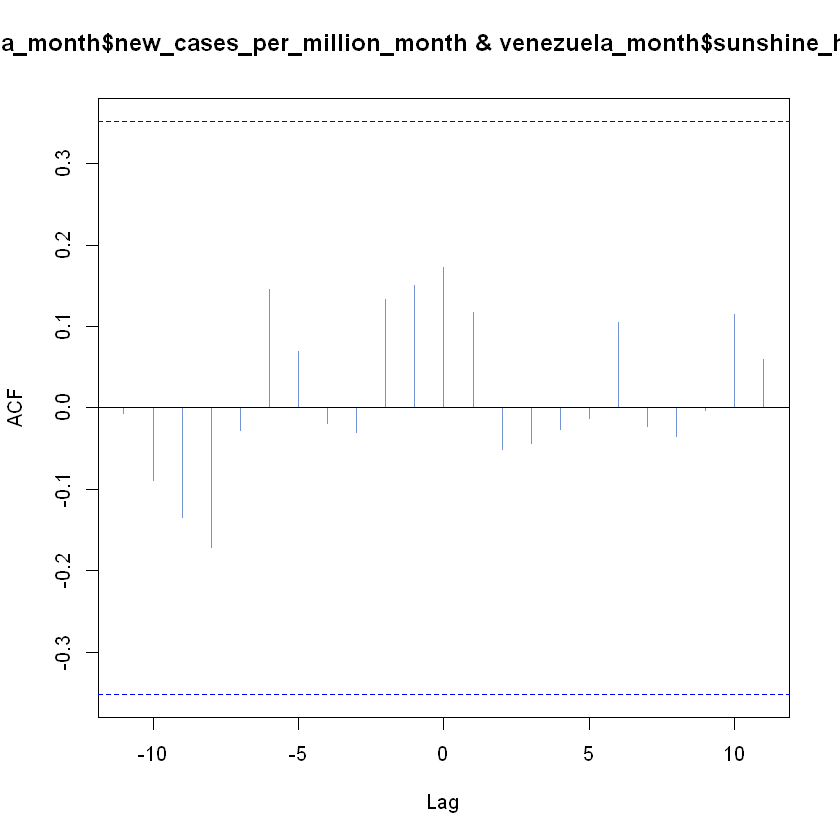

In [82]:
venezuela_month <-
    monthly_cases_per_million %>%
    filter(iso_code == "VEN") # filter for iso code "VEN"
ccf(venezuela_month$new_cases_per_million_month, venezuela_month$sunshine_hours_month, col = "#7294D4") # put "new_cases_per_million_month" and "sunshine_hours_month" through the sample cross correlation function

For Venezuela, the strongest correlation between `new_cases_per_million_month` and `sunshine_hours_month` is 0.1728714 at lag 0.<br>
The correlation is low without a clear seasonal pattern.

Based on these findings, there is a correlation between the monthly total sunshine duration of a country and its monthly number of confirmed cases over the timeline. The strength of the correlation varies between countries as we saw between Czech Republic (-0.813) and Venezuela (0.173). The lag where the maximum absolute value of `ccf.acf` was observed varies between countries too.

# Conclusion<a name="conclusion"></a>

* There is a moderate correlation between the yearly total sunshine duration in a country and their total confirmed cases.<br><br>

* Government Response Stringency Index on the other hand has no effect on the country's total confirmed cases.<br><br>

* Cross-correlation between two different time series, monthly sunshine duration and monthly confirmed cases, show that 30.89% of countries have high correlation, 55.28% of countries have medium correlation, and 13.82% of countries have low correlation. None of the countries were found to have no correlation.<br><br>

* When looking at this cross-correlation by continents, countries in Europe have the highest correlation between monthly sunshine duration and monthly confirmed cases.<br><br>

* Sunshine duration could potentially be useful to predict COVID cases in the future, especially for countries with moderate to high correlations.

#  References<a name="ref"></a>

1. <a name="1"></a>Walrand, S. Autumn COVID-19 surge dates in Europe correlated to latitudes, not to temperature-humidity, pointing to vitamin D as contributing factor. Sci Rep 11, 1981 (2021). https://doi.org/10.1038/s41598-021-81419-w
2. <a name="2"></a>Wikipedia, “Sunshine duration,” Wikipedia [website], [no date], para. 1, <https://en.wikipedia.org/wiki/Sunshine_duration>, accessed November 3, 2022.
3. <a name="3"></a>Our World in Data, "covid-19-data," GitHub [website], [no date], <https://github.com/owid/covid-19-data/tree/master/public/data>, accessed October 23, 2022.
4. <a name="4"></a>Wikipedia, “List of cities by sunshine duration,” Wikipedia [website], [no date], <https://en.wikipedia.org/wiki/List_of_cities_by_sunshine_duration>, accessed November 3, 2022.
5. <a name="5"></a>Cohen, Jacob. <em>Statistical Power Analysis for the Behavioral Sciences</em>. 2nd ed., Taylor & Francis, 2013. University of Toronto Faculty of Arts & Science, https://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf. Accessed November 6, 2022.